In [1]:
# import os
import glob
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib as mpl
from matplotlib.lines import Line2D
%matplotlib inline
import matplotlib.pyplot as plt
import re
from matplotlib import gridspec
import scipy.stats as stats
from scipy.stats import gaussian_kde
import seaborn as sns
import itertools
import os


import baltic as bt
import time

from collections import OrderedDict
from matplotlib import rcParams 
# from matplotlib import style
from matplotlib.colors import ListedColormap # control color in seaborn heatmap
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects
# matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)
# style.use('ggplot')

# print rcParams.keys()

try:
    from itertools import product
except ImportError:
    # product is new in v 2.6
    def product(*args, **kwds):
        pools = map(tuple, args) * kwds.get('repeat', 1)
        result = [[]]
        for pool in pools:
            result = [x+[y] for x in result for y in pool]
        for prod in result:
            yield tuple(prod)

def logMatrix(matrix):
    transformed_matrix=[]
    transformed_matrix=np.log10(matrix+1)
    return transformed_matrix

def logMatrixWNeg(matrix):
    transformed_matrix=[]
    transformed_matrix=np.log10(matrix-matrix.min()+1)
    return transformed_matrix

----

# Create a centralised dataset with all variables and write the scripts to run mcmcGLMM in R

----

## 1. Upload the databases

The following will be the master database to store all variables once they are transformed and missing data is figured out.
Each dataset comes from collaborators, our own work, or published data.

In [2]:
# database with leaf shapes coded at the genus level by CD. Bacon and at the species level by MF.Torres
leafshape=pd.read_csv('../data_files/palm_leaf_shape_MFT_20220609.txt',sep='\t')
# PalmTraits v.1.0 from Kissling et al., 2019
palmtrait_kissling=pd.read_csv('../data_files/PalmTraits_1.0.txt')
# bioClim and soil variables for all GBIF records
bioenv_extract=pd.read_csv('../data_files/../data_files/GBIF_arecaceae_chelsa_FH_20220503.csv',sep='\t') #### tHIS ONE DOESN'T HAVE CEONTRIDS :) i JUST FORGOT TO WRITE IT IN THE OUTPUT NAME
# spines and biome dataset were coded by Soren Faurby and Christine D. Bacon
biome_bdb_sf=pd.read_csv('../data_files/Spine_Data_Per_palm_SF_CDB_20200603.txt',sep='\t')
biome_bdb_sf['species_name']=['%s_%s'%(row.Genus,row.Species) for row in biome_bdb_sf.itertuples()]
# biome_bdb_sf

In [3]:
bioenv_extract.columns

Index(['Unnamed: 0', 'basisOfRecord', 'coordinateUncertaintyInMeters',
       'countryCode', 'decimalLatitude', 'decimalLongitude', 'family',
       'gbifID', 'individualCount', 'institutionCode', 'species', 'taxonRank',
       'year', 'CHELSA_ai', 'CHELSA_bio10', 'CHELSA_bio11', 'CHELSA_bio12',
       'CHELSA_bio13', 'CHELSA_bio14', 'CHELSA_bio15', 'CHELSA_bio16',
       'CHELSA_bio17', 'CHELSA_bio18', 'CHELSA_bio19', 'CHELSA_bio1',
       'CHELSA_bio2', 'CHELSA_bio3', 'CHELSA_bio4', 'CHELSA_bio5',
       'CHELSA_bio6', 'CHELSA_bio7', 'CHELSA_bio8', 'CHELSA_bio9',
       'CHELSA_cmi_max', 'CHELSA_cmi_mean', 'CHELSA_cmi_min',
       'CHELSA_cmi_range', 'CHELSA_fcf', 'CHELSA_gdd0', 'CHELSA_gdgfgd0',
       'CHELSA_gsl', 'CHELSA_gst', 'CHELSA_hurs_max', 'CHELSA_hurs_min',
       'CHELSA_hurs_range', 'CHELSA_lgd', 'CHELSA_ngd0', 'CHELSA_npp',
       'CHELSA_vpd_max', 'CHELSA_vpd_mean', 'CHELSA_vpd_min',
       'Simard_Pinto_3DGlobalVeg_JGR'],
      dtype='object')

## 2. Parse Kew's accepted and synonym species lists and count missing species

In [4]:
# Creating metadata dictionaries from parsing the Kew species list information
# file saved with UTF-8
# removed symbol *
kew_html_path='../data_files/Native_species_to_btocountries.html'
species_areas_dict={}
species_synon_dict={}
for line in open(kew_html_path,'r',encoding="utf8"):
    # detects the species count line and doesn't take it as species line (it is genus line)
    speciescountmatch=re.search('rptDetNameSpcCount',line)
    genuscountmatch=re.search('Arecaceae',line)
    # skips lines with irrelevant information
    if speciescountmatch or genuscountmatch:
        pass
    else:
        detnamematch=re.search('rptDetName',line)
        if detnamematch:
            # fetching information
            speciesmatch=re.search('<i><b>([A-Z][a-z]+)</b><b> ([a-z-]+)</b></i>',line) # note the space
            areamatch=re.search('"rptDetNameDescription">(.+?)</p>',line)
            synonmatch=re.findall('("rptDetNameSynonyms"> <i>[A-Z][a-z]+</i><i> [a-z-]+</i>.+</p>)',line)
            
            # asigning
            species='%s_%s'%(speciesmatch.group(1),speciesmatch.group(2)) if speciesmatch else 'None'
            species_areas_dict[species]=re.findall('([A-Z][A-Z][A-Z])+',areamatch.group(0)) if areamatch else 'None'
            
            synonyms=re.findall('([A-Z][a-z]+</i><i> [a-z-]+)</i> ',line)# if synonmatch else None
            species_synon_dict[species]=[x.replace('</i><i> ','_') for x in synonyms] if synonmatch else 'none'
# print(species_areas_dict)
# print(species_synon_dict)
data=pd.DataFrame()
# print(list(species_areas_dict))
data['species']=list(species_areas_dict.keys())
data['areas']=data['species'].map(species_areas_dict)
data['synonyms']=data['species'].map(species_synon_dict)
data=data[data['species']!='None']
data

,species,areas,synonyms
0,Acanthophoenix_crinita,[REU],[Areca_crinita]
1,Acanthophoenix_rousselii,[REU],none
2,Acanthophoenix_rubra,"[MAU, REU]","[Areca_rubra, Calamus_verschaffeltii, Sublimia..."
3,Acoelorraphe_wrightii,"[FLA, MXG, MXT, BLZ, COS, GUA, HON, NIC, BAH, ...","[Copernicia_wrightii, Paurotis_wrightii, Seren..."
4,Acrocomia_aculeata,"[MXG, MXS, MXT, BLZ, COS, ELS, GUA, HON, NIC, ...","[Cocos_aculeata, Acrocomia_sclerocarpa, Palma_..."
...,...,...,...
2530,Wettinia_quinaria,"[CLM, ECU]","[Wettinella_quinaria, Wettinia_utilis]"
2531,Wettinia_radiata,"[PAN, CLM]","[Catostigma_radiatum, Catoblastus_radiatus, Ca..."
2532,Wettinia_verruculosa,"[CLM, ECU]",none
2533,Wodyetia_bifurcata,[QLD],none


In [5]:
# add a columns with the genus information
data['genus']=''
data['species']=data['species'].astype(str)
for index,row in data.iterrows():
    tempatch=re.search('([A-Za-z]+)_([a-z]+.[a-z]+)',row['species'])
#     print(tempatch.group(1) if tempatch else '')
    data.loc[index,'genus']=tempatch.group(1) if tempatch else 'none'
data

,species,areas,synonyms,genus
0,Acanthophoenix_crinita,[REU],[Areca_crinita],Acanthophoenix
1,Acanthophoenix_rousselii,[REU],none,Acanthophoenix
2,Acanthophoenix_rubra,"[MAU, REU]","[Areca_rubra, Calamus_verschaffeltii, Sublimia...",Acanthophoenix
3,Acoelorraphe_wrightii,"[FLA, MXG, MXT, BLZ, COS, GUA, HON, NIC, BAH, ...","[Copernicia_wrightii, Paurotis_wrightii, Seren...",Acoelorraphe
4,Acrocomia_aculeata,"[MXG, MXS, MXT, BLZ, COS, ELS, GUA, HON, NIC, ...","[Cocos_aculeata, Acrocomia_sclerocarpa, Palma_...",Acrocomia
...,...,...,...,...
2530,Wettinia_quinaria,"[CLM, ECU]","[Wettinella_quinaria, Wettinia_utilis]",Wettinia
2531,Wettinia_radiata,"[PAN, CLM]","[Catostigma_radiatum, Catoblastus_radiatus, Ca...",Wettinia
2532,Wettinia_verruculosa,"[CLM, ECU]",none,Wettinia
2533,Wodyetia_bifurcata,[QLD],none,Wodyetia


In [6]:
# creates a dictionary with the synonym name (keys) and accepted name (values)
# some accepted species might have several synonym species associated to them, but synonym species will have a single "current" accepted species
syn_spp_dict={}
for index,row in data[data['synonyms']!='none'].iterrows():
    for x in row['synonyms']:
        syn_spp_dict[x]=row['species']
# syn_spp_dict

In [7]:
## we need to add the species missing GBIF data but that can be annotated with morphological data.
## check how many and which species are missing
spp_inbio=sorted(bioenv_extract['species'].unique())
all_palmspp=data['species'].values
missing_spp=list(set(all_palmspp)-set(spp_inbio)) # accepted species missing in the bio database

# checking missing in GBIF from the palmleaf shape database
sppleafshape=leafshape['species'].unique()
missingfromshape_spp=list(set(sppleafshape)-set(all_palmspp)) # already have what is missed in bio, now what is missed in leafshape
missing_all=sorted(set(missingfromshape_spp+missing_spp))

print('Number of palm species considered: ',len(all_palmspp)) # accepted, not accepted, etc
print('Number of palm species with GBIF data: ',len(spp_inbio))
print('Number of palm species with leaf shape data: ',len(leafshape['species'].unique()))
print('Number of palm species with no GBIF data: ',len(missing_spp))
print('Number of palm species with no leaf shape data: ',len(missingfromshape_spp))
print('Total number of palm species with no data: ',len(missing_all))
print('\n\nAll palm species missing:\n',missing_all)  # can be species that aren't accepted as species yet, species missing from the tree but with data (excluded) or species with either GBIF or leaf shape (or both) data missing

Number of palm species considered:  2534
Number of palm species with GBIF data:  1908
Number of palm species with leaf shape data:  2648
Number of palm species with no GBIF data:  626
Number of palm species with no leaf shape data:  186
Total number of palm species with no data:  812


All palm species missing:
 ['Acanthophoenix_crinita', 'Acanthophoenix_rousselii', 'Acanthophoenix_rubra', 'Acoelorraphe_wrightii', 'Acrocomia_corumbaensi', 'Adonidia_dransfieldii', 'Aiphanes_minima', 'Allagoptera_campestris', 'Areca_ahmadii', 'Areca_andersonii', 'Areca_bakeri', 'Areca_camarinensis', 'Areca_congesta', 'Areca_ipot', 'Areca_jokowi', 'Areca_ledermanniana', 'Areca_mandacanii', 'Areca_montana', 'Areca_parens', 'Areca_ridleyana', 'Areca_triandra', 'Areca_triginticollina', 'Areca_tunku', 'Arenga_distincta', 'Arenga_listeri', 'Arenga_longicarpa', 'Arenga_longipes', 'Arenga_mindorensis', 'Arenga_ryukyuensis', 'Arenga_talamauensis', 'Asterogyne_guianensis', 'Astrocaryum_aculeatum', 'Astrocaryum_gig

## 3. Estimate species medians of the GBIF data

In [8]:
## Calculating median values for bio and soil variables. From now on, coordinate information is not longer useful as it becomes median coordinate points.
# grouping by species is useful for making the annotation of other variables and species synonyms easier and faster
# we are creating the palms_all_variables database that will become the master database
palms_all_variables_pre=bioenv_extract.groupby(['species']).median().reset_index()
palms_all_variables_pre.drop(labels='Unnamed: 0',axis=1,inplace=True)
palms_all_variables_pre

,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,CHELSA_ai,CHELSA_bio10,CHELSA_bio11,...,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR
0,Acrocomia_aculeata,80.0,8.555854,-75.696278,2.423127e+09,1.0,2009.0,-99999.000000,224.5,181.5,...,6288.0,5785.0,363.0,0.0,365.0,9905.0,11266.0,9908.0,8904.0,0.0
1,Acrocomia_crispa,514.5,21.616574,-77.756928,1.929436e+09,NaN,1916.0,-99999.000000,189.5,147.5,...,6033.0,5877.0,156.0,19.0,365.0,3650.0,8902.0,7782.0,6709.0,0.0
2,Acrocomia_emensis,NaN,-20.775000,-47.308334,2.452918e+09,4.0,1990.5,-99999.000000,264.0,243.5,...,6330.0,5810.5,548.0,0.0,365.0,12343.0,12938.0,12615.0,12394.5,0.0
3,Acrocomia_glaucescens,NaN,-16.655692,-54.684167,1.261911e+09,NaN,2009.0,-99999.000000,269.5,256.5,...,6400.0,5995.0,410.5,0.0,365.0,19142.0,13284.0,12886.0,12366.0,0.0
4,Acrocomia_hassleri,850.0,-23.809420,-55.733194,1.258407e+09,4.0,1997.0,-99999.000000,268.5,243.5,...,6287.0,5863.0,423.0,0.0,365.0,14542.0,13260.0,12807.0,12278.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,Wettinia_quinaria,204.0,3.810555,-77.280000,1.890957e+09,1.0,2000.5,1.214225,107.5,100.5,...,6921.0,6030.0,914.0,0.0,365.0,11244.0,5196.0,4371.0,3688.0,28.0
1904,Wettinia_radiata,3017.0,5.733889,-76.912222,1.703264e+09,1.0,1985.0,0.789417,116.5,105.5,...,7006.0,6052.0,1130.0,11.0,365.0,6745.0,4433.0,3559.0,2837.0,32.0
1905,Wettinia_verruculosa,2047.0,0.916667,-78.100000,1.260309e+09,3.0,1987.0,0.927436,141.5,134.5,...,6893.0,5866.0,993.0,0.0,365.0,14257.0,6454.0,5534.0,4917.0,27.0
1906,Wodyetia_bifurcata,10000.0,-16.900000,145.700000,1.917075e+09,1.0,1998.0,-99999.000000,272.5,267.5,...,6495.0,6239.0,237.0,0.0,365.0,24996.0,13223.0,12932.0,12561.0,0.0


In [9]:
## now, adding the rows with species with no GBIF data but that are in the tree and HAVE LEAF and MORPHOLOGICAL data
missing_spp_df=pd.DataFrame()
for column in palms_all_variables_pre.columns:
    missing_spp_df[column]=[np.nan]*len(missing_all)
missing_spp_df['species']=missing_all
missing_spp_df.dropna(subset=['species'],inplace=True)
missing_spp_df

,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,CHELSA_ai,CHELSA_bio10,CHELSA_bio11,...,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR
0,Acanthophoenix_crinita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acanthophoenix_rousselii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Acanthophoenix_rubra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Acoelorraphe_wrightii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Acrocomia_corumbaensi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,Verschaffeltia_splendida,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
808,Wallaceodoxa_raja-ampat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
809,Wallichia_marianneae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
810,Wallichia_triandra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
palms_all_variables=pd.DataFrame()
# palms_all_variables
# concatenate the DF with species that have GBIF coordinates and the DF with the species missing, to annotate all variables in the same DF regardless of which species are in which DB.
withgbif=palms_all_variables_pre
palms_all_variables=pd.concat([withgbif,missing_spp_df]).reset_index()
palms_all_variables

,index,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,CHELSA_ai,CHELSA_bio10,...,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR
0,0,Acrocomia_aculeata,80.0,8.555854,-75.696278,2.423127e+09,1.0,2009.0,-99999.0,224.5,...,6288.0,5785.0,363.0,0.0,365.0,9905.0,11266.0,9908.0,8904.0,0.0
1,1,Acrocomia_crispa,514.5,21.616574,-77.756928,1.929436e+09,NaN,1916.0,-99999.0,189.5,...,6033.0,5877.0,156.0,19.0,365.0,3650.0,8902.0,7782.0,6709.0,0.0
2,2,Acrocomia_emensis,NaN,-20.775000,-47.308334,2.452918e+09,4.0,1990.5,-99999.0,264.0,...,6330.0,5810.5,548.0,0.0,365.0,12343.0,12938.0,12615.0,12394.5,0.0
3,3,Acrocomia_glaucescens,NaN,-16.655692,-54.684167,1.261911e+09,NaN,2009.0,-99999.0,269.5,...,6400.0,5995.0,410.5,0.0,365.0,19142.0,13284.0,12886.0,12366.0,0.0
4,4,Acrocomia_hassleri,850.0,-23.809420,-55.733194,1.258407e+09,4.0,1997.0,-99999.0,268.5,...,6287.0,5863.0,423.0,0.0,365.0,14542.0,13260.0,12807.0,12278.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,807,Verschaffeltia_splendida,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2716,808,Wallaceodoxa_raja-ampat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2717,809,Wallichia_marianneae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2718,810,Wallichia_triandra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Check compatibility between database and tree-tip names

In [23]:
## add a column with the species name as appears in the tip of the phylogeny
treeFileNexus='../data_files/Clean_1_1_MCCT_nexus.nex'
cc=bt.loadNexus(treeFileNexus,absoluteTime=False,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file

cc.treeStats()
cc.drawTree()
cc.sortBranches()
cc.setAbsoluteTime(2019.0)


Tree height: 108.328870
Tree length: 18144.538310
strictly bifurcating tree
annotations present

Numbers of objects in tree: 5099 (2549 nodes and 2550 leaves)



In [12]:
# creates a list of species in the tree
tip_species=[]
for k in cc.Objects:
    if k.branchType=='leaf' and k.name not in tip_species:
        tip_species.append(k.name)
        
print('Number of species in the tree: ',len(tip_species))

for row in palms_all_variables.itertuples():
    if row.species in tip_species: # if matches, just leave it at that
        palms_all_variables.loc[row.Index,'tip_name']=row.species
    elif row.species in syn_spp_dict.values(): # if there's no match.. check if the synonym of the species is in the tree and place it there. # if the species name is not in the tree, it is likely that the synonym is in the tree.
        for key,value in syn_spp_dict.items(): # then we need to connect the accepted species to the synonym tree tip.
            if row.species==value and key in tip_species: # if species in db is accepted and its synonym key is in the tree
                palms_all_variables.loc[row.Index,'tip_name']=key

# prints the non-empty tipname dataframe and two columns, species and tip_names
palms_all_variables[palms_all_variables['tip_name']!=''][['species','tip_name']] # sanity check

Number of species in the tree:  2550


,species,tip_name
0,Acrocomia_aculeata,Acrocomia_aculeata
1,Acrocomia_crispa,Acrocomia_crispa
2,Acrocomia_emensis,Acrocomia_emensis
3,Acrocomia_glaucescens,Acrocomia_glaucescens
4,Acrocomia_hassleri,Acrocomia_hassleri
...,...,...
2715,Verschaffeltia_splendida,Verschaffeltia_splendida
2716,Wallaceodoxa_raja-ampat,Wallaceodoxa_raja-ampat
2717,Wallichia_marianneae,Wallichia_marianneae
2718,Wallichia_triandra,Wallichia_triandra


In [13]:
spp_notintree=palms_all_variables[palms_all_variables['tip_name'].isna()]['species'].values
# the list has items in accepted species with synonyms, but it doesnt have items in the synonym-toaccepted dictionary.
print('Number of species in the datasets but not in the tree: ',len(spp_notintree))
spp_notintree

Number of species in the datasets but not in the tree:  170


array(['Aiphanes_argos', 'Aiphanes_truncata', 'Calamus_cinereus',
       'Calamus_heatubunii', 'Calamus_manglaensis', 'Calamus_nuralievii',
       'Calamus_pintaudii', 'Calamus_tadulakoensis', 'Dypsis_aurantiaca',
       'Dypsis_mijoroana', 'Dypsis_ovojavavy', 'Dypsis_rabepierrei',
       'Lanonia_gialaiensis', 'Lanonia_poilanei', 'Lanonia_verrucosa',
       'Licuala_caespitosa', 'Raphia_gabonica', 'Raphia_zamiana',
       'Sabal_antillensis', 'Syagrus_amicorum', 'Syagrus_guaratingensis',
       'Synechanthus_dasystachys', 'Wettinia_donosoensis',
       'Acrocomia_corumbaensi', 'Areca_jokowi', 'Astrocaryum_gynacanthum',
       'Attalea_minarum', 'Attalea_pacensis', 'Attalea_piassabossu',
       'Attalea_rhynchocarpa', 'Attalea_teixeirana', 'Attalea_voeksii',
       'Bactris_hondurensis', 'Balaka_brachychlamys', 'Balaka_minuta',
       'Balaka_tuasivica', 'Butia_arenicola', 'Butia_missionera',
       'Butia_poni', 'Calamus_africanus', 'Calamus_arfakianus',
       'Calamus_baiyerensis', 

In [14]:
# search for above species in the Kissling and gbif database, see if there's info to recover for them
leafshape[leafshape['species'].isin(spp_notintree)]
palmtrait_kissling[palmtrait_kissling['SpecName'].isin(spp_notintree)] # Calamus_rumphii , Calamus_scabrispathus species in kissling not in tree
bioenv_extract[bioenv_extract['species'].isin(spp_notintree)]['species'].unique() # Aiphanes_truncata in gbif not in tree
palms_all_variables[palms_all_variables['species'].isin(spp_notintree)] ## all species not in tree are already included in the database. Go ahead, this is as much data as we can recover.

,index,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,CHELSA_ai,CHELSA_bio10,...,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR,tip_name
14,14,Aiphanes_argos,NaN,6.034861,-74.912222,2.268907e+09,1.0,2015.5,2.075062,102.0,...,6567.0,590.5,0.0,365.0,13532.0,3885.0,3704.0,3477.5,13.0,NaN
39,39,Aiphanes_truncata,NaN,-14.990000,-68.320000,4.753301e+08,1.0,2010.0,1.041168,301.5,...,4928.0,1756.0,43.0,365.0,19463.0,22411.0,15218.0,11249.0,0.0,NaN
381,381,Calamus_cinereus,NaN,11.330000,107.830000,1.930369e+09,NaN,2016.0,-99999.000000,264.5,...,5627.0,623.0,0.0,365.0,8379.0,13691.0,12601.0,11700.0,0.0,NaN
445,445,Calamus_heatubunii,0.2,-0.913889,131.350000,2.845795e+09,NaN,2013.0,-99999.000000,272.5,...,6355.0,157.0,0.0,365.0,22988.0,13183.0,12336.0,11348.0,0.0,NaN
493,493,Calamus_manglaensis,NaN,14.703200,108.337500,1.930502e+09,NaN,2015.0,-99999.000000,250.5,...,5486.5,906.5,38.5,365.0,5725.0,12727.0,11508.0,10685.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2696,788,Syagrus_cataphracta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2697,789,Syagrus_elata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2698,790,Syagrus_matafome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2700,792,Syagrus_pimentae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 5. Find typos across datasets and fix them

In [15]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [16]:
palmtrait_kissling.columns # DB joint by 'SpecName'

Index(['SpecName', 'accGenus', 'accSpecies', 'PalmTribe', 'PalmSubfamily',
       'Climbing', 'Acaulescent', 'Erect', 'StemSolitary', 'StemArmed',
       'LeavesArmed', 'MaxStemHeight_m', 'MaxStemDia_cm', 'UnderstoreyCanopy',
       'MaxLeafNumber', 'Max_Blade_Length_m', 'Max_Rachis_Length_m',
       'Max_Petiole_length_m', 'AverageFruitLength_cm', 'MinFruitLength_cm',
       'MaxFruitLength_cm', 'AverageFruitWidth_cm', 'MinFruitWidth_cm',
       'MaxFruitWidth_cm', 'FruitSizeCategorical', 'FruitShape',
       'FruitColorDescription', 'MainFruitColors', 'Conspicuousness'],
      dtype='object')

In [17]:
biome_bdb_sf.columns # DB joint by 'species_name'

Index(['Genus', 'Species', 'Spines', 'Climbing', 'StemHeight',
       '1_Tropical_and_subtropical_moist_broadleaf_forests',
       '2_Tropical_and_subtropical_dry_broadleaf_forests',
       '3_Tropical_and_subtropical_coniferous_forests',
       '4_Temperate_broadleaf_and_mixed_forests',
       '5_Temperate_coniferous_forest',
       '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands',
       '8_Temperate_grasslands_savannas_and_shrublands',
       '12_Mediterranean_Forests_woodlands_and_scrubs',
       '13_Desert_and_xeric_shrublands', 'species_name'],
      dtype='object')

In [18]:
leafshape.columns # DB joint by 'species'

Index(['species', 'subfamily', 'plication_all', 'shape_all', 'polymorphism',
       'dissection', 'induplicate', 'ind_variable', 'ind_cospalmate',
       'ind_pinnate', 'ind_entire', 'ind_bipinnate', 'reduplicate',
       'red_variable', 'red_variance', 'red_cospalmate', 'red_pinnate',
       'red_entire'],
      dtype='object')

In [19]:
# first, create a list of uncommon species .. i.e. entries that are not identical
diff_palms_leafshape=[x for x in palms_all_variables['species'].unique() if x not in leafshape['species'].unique()] # tip_names is a column with exact tree-palmDB matches. need to evaluate tree tips directly later.
diff_palms_kissling=[x for x in palms_all_variables['species'].unique() if x not in palmtrait_kissling['SpecName'].unique()]
diff_biome=[x for x in palms_all_variables['species'].unique() if x not in biome_bdb_sf['species_name'].unique()]
diff_palms_tree=[x for x in palms_all_variables['species'].unique() if x not in tip_species]

print('Species in global DB missing in leafshape: %s'%(len(diff_palms_leafshape)))
print('Species in global DB missing in kissling: %s'%(len(diff_palms_kissling)))
print('Species in global DB missing in biome: %s'%(len(diff_biome)))
print('Species in global DB missing in tree: %s'%(len(diff_palms_tree)))

Species in global DB missing in leafshape: 72
Species in global DB missing in kissling: 293
Species in global DB missing in biome: 171
Species in global DB missing in tree: 170


In [20]:
# now, the opposite, whatever is in the databases that is not in the palmsdb palms_all_variables['species'].unique()
diff_leafshape_palmsdb=[x for x in leafshape['species'].unique() if x not in palms_all_variables['species'].unique()] # tip_names is a column with exact tree-palmDB matches. need to evaluate tree tips directly later.
diff_kissling_palmsdb=[x for x in palmtrait_kissling['SpecName'].unique() if x not in palms_all_variables['species'].unique()]
diff_biome_palmsdb=[x for x in biome_bdb_sf['species_name'].unique() if x not in palms_all_variables['species'].unique()]
diff_tree_palmsdb=[x for x in tip_species if x not in palms_all_variables['species'].unique()]

print('Species in leafshape but missing in global DB: %s'%(len(diff_leafshape_palmsdb)))
print('Species in kissling but missing in global DB: %s'%(len(diff_kissling_palmsdb)))
print('Species in biome but missing in global DB: %s'%(len(diff_biome_palmsdb)))
print('Species in tree but missing in global DB: %s'%(len(diff_tree_palmsdb)))

Species in leafshape but missing in global DB: 0
Species in kissling but missing in global DB: 130
Species in biome but missing in global DB: 1
Species in tree but missing in global DB: 0


In [21]:
# now that we know items that are in one side but not the other (the rest we assume are correct entries), we compare them to detect typos
typos_test=pd.DataFrame()
typos_test['in_palmsdb']=''
typos_test['in_otherdb']=''
typos_test['fuzz_ratio']=''
typos_test['test']=''
data=[]
test_dict={1:'leafshape',2:'kissling',3:'tree',4:'biome'}
testname=0
for db1,db2 in [(diff_palms_leafshape,diff_leafshape_palmsdb),(diff_palms_kissling,diff_kissling_palmsdb),(diff_palms_tree,diff_tree_palmsdb),(diff_biome,diff_biome_palmsdb)]: #  db1,db2 are the db tuples in the list e.g. diff_palms_leafshape=db1,diff_leafshape_palmsdb=db2
    testname=testname+1
    cols=['in_palmsdb','in_otherdb','fuzz_ratio','test']
    tempiter=[(x,y) for x in db1 for y in db2]
    for x,y in tempiter:
        tempfuzz=fuzz.ratio(x,y)
        if 80 < tempfuzz < 100:
            data.append(dict(zip(cols,[x,y,tempfuzz,testname])))

typos_test=typos_test.append(data,ignore_index=True)
typos_test['test'].unique() # test1 and test3 has db2=empty because there are no species in one db but not the other!
typos_test['test']=typos_test['test'].map(test_dict)
typos_test.to_csv('../data_files/typose_to_solve_20220617.csv',sep='\t')
typos_test # mostly Calamus species that are ambiguous

,in_palmsdb,in_otherdb,fuzz_ratio,test
0,Calamus_badius,Calamus_acidus,86,kissling
1,Calamus_badius,Calamus_albus,81,kissling
2,Calamus_brevicaulis,Calamus_brevifolius,84,kissling
3,Calamus_fissus,Calamus_fuscus,86,kissling
4,Calamus_sabut,Calamus_albus,85,kissling
5,Calamus_ursinus,Calamus_fuscus,83,kissling
6,Calamus_validus,Calamus_acidus,90,kissling
7,Calamus_validus,Calamus_albus,86,kissling
8,Calamus_confusus,Calamus_fuscus,87,kissling
9,Calamus_fucus,Calamus_acidus,81,kissling


## 6. Annotate leaf shape

In [22]:
# annotate leafshape
shape_fields=['dissection','induplicate','ind_variable','ind_cospalmate','ind_pinnate','ind_entire','ind_bipinnate','reduplicate','red_variable','red_cospalmate','red_pinnate','red_entire']

# non trivial problem: in the species column there might be some synonyms. Just adding a column of synonyms and mapping dictionaries (from DB with varying species names) to syns and then species might ignore the synonym species in the species column.
for shape in shape_fields:
    # keys here might be synonyms instead of accepted species names
    tempdic=dict(zip(leafshape['species'],leafshape[shape]))
    palms_all_variables[shape]=np.nan
    for row in palms_all_variables.itertuples():
        for key,value in syn_spp_dict.items(): # iterating through synonyms. first deal with synonyms... next loop dealing with accepted species will overwrite leafshape if synonym and accepted species coexist and the accepted shape will be favoured.
            if row.species == value and key in leafshape['species'].values: # if accepted species in db is a value in the synonym:accepted dict, and the accepted spp is in the leafshape list:
                palms_all_variables.loc[row.Index,shape]=tempdic[key] # fetch the value of the synonym and place it in the row of the accepted species
            if row.species in tempdic.keys():   
                palms_all_variables.loc[row.Index,shape]=tempdic[row.species] # if accepted in database (rewrittes spp with synonyms if accepted spp also in database)
palms_all_variables


KeyboardInterrupt



#### -> Checkpoint: DB with BIOCLIM, soil and shape variables

#### Visualising the data.

This plot doesn't intend to be a sumarry but rather a very explicit view of the data to help us spot potential errors in the coding of leaf shape.

Species with no colours are not in the tree nor in PalmWeb

In [ ]:
fig,ax=plt.subplots(figsize=(5,500),facecolor='w')
ax.set_xlim(0,20)
ax.set_ylim(len(palms_all_variables),-5)
cols=['induplicate', 'ind_variable', 'ind_cospalmate',
       'ind_pinnate', 'ind_entire', 'ind_bipinnate', 'reduplicate',
       'red_variable', 'red_cospalmate', 'red_pinnate',
       'red_entire']

temp=palms_all_variables.sort_values(by='species').copy(deep=True)
temp1=temp[cols].replace('none',0).replace(np.nan,0).replace('pinnate_entire',0).replace(11,1).astype('float').copy(deep=True)
# iloc[rows,columns]
indup_dict={1:'#fc5d00',0:'#bababa',np.nan:'#bababa','nan':'#bababa'}
redup_dict={1:'#43d164',0:'#bababa',np.nan:'#bababa','nan':'#bababa'}

height=1
width=1
offset=1
for y in range(0,len(temp1),1):
    ax.text(0.5,y+0.5,s=temp.iloc[y,1],fontsize=10,ha='right')
    for x in range(0,6,1): # all induplicates
        ax.bar(x=offset+x,height=height,width=width,bottom=y,align='edge',
               facecolor=indup_dict[temp1.iloc[y,x]],edgecolor='w',alpha=1 if cols[x] !='induplicate' else 0.6)

    for x in range(0,5,1): # all reduplicates
        ax.bar(x=6+offset+x,height=height,width=width,bottom=y,align='edge',
               facecolor=redup_dict[temp1.iloc[y,x+6]],edgecolor='w',alpha=1 if cols[x+6] !='reduplicate' else 0.6)

for x in range(0,len(cols)):
    ax.text(x+offset+1,-1,s=cols[x],rotation=90,ha='right',fontsize=10)
    
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax.tick_params(size=0)
ax.set_xticklabels([]) ; ax.set_yticklabels([])

plt.show()

In [ ]:
# need to create the shape summary column
# and a summary column (binary) per shape ignoring plication

#annotate the file correctly
for index,row in palms_all_variables.iterrows():
    palms_all_variables.loc[index,'plication']='reduplicate'
    if row['induplicate'] == 1:
        palms_all_variables.loc[index,'plication']='induplicate'

palms_all_variables['dissect']=''
for index,row in palms_all_variables.iterrows():
    palms_all_variables.loc[index,'dissect']='dissected'
    if row['dissection'] == 0:
        palms_all_variables.loc[index,'dissect']='entire'
        
palms_all_variables['shape']=''
shapes=['ind_cospalmate','ind_pinnate','ind_entire','ind_bipinnate',
        'red_cospalmate','red_pinnate','red_entire']
for shape in shapes:
    for index,row in palms_all_variables.iterrows():
        if float(row[shape]) == 1.0:
            shapematch=re.match('(.+)_(.+)',shape)
            palms_all_variables.loc[index,'shape']=shapematch.group(2) if shapematch else np.nan

palms_all_variables['variation']=''        
for index,row in palms_all_variables.iterrows():
    palms_all_variables.loc[index,'variation']='not_variable'
    if row['ind_variable'] == 1:            
        palms_all_variables.loc[index,'variation']='variable'
    elif row['red_variable'] == 1:
        palms_all_variables.loc[index,'variation']='variable'

for index,row in palms_all_variables.iterrows():
    if row['variation']=='variable':
        palms_all_variables.loc[index,'shape']='variable'

print(palms_all_variables['plication'].unique())
print(palms_all_variables['shape'].unique())
print(palms_all_variables['variation'].unique())

In [ ]:
# finally, a column per shape in binary values, ignoring plication
#cos-palmate_binomial
for shape in ['cospalmate','pinnate','entire','variable','bipinnate']:
    palms_all_variables['%s_binomial'%(shape)]='false'
    for index,row in palms_all_variables.iterrows():
        if row['shape']==shape:
            palms_all_variables.loc[index,'%s_binomial'%(shape)]='true'
palms_all_variables[['cospalmate_binomial','pinnate_binomial','entire_binomial','variable_binomial','bipinnate_binomial']].describe()

In [ ]:
palms_all_variables['dissect'].describe()

## 7. Annotate PalmTraits1 (Kissling et al., 2019)

In [ ]:
palmtrait_kissling.columns

In [ ]:
len(palms_all_variables[palms_all_variables['tip_name']!='']['species'].unique())

In [ ]:
# annotate leafshape
kissling=['PalmTribe','PalmSubfamily','Climbing', 'Acaulescent','MaxStemHeight_m','MaxStemDia_cm','MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m','Max_Petiole_length_m','UnderstoreyCanopy']

for shape in kissling:
    # keys here might be synonyms instead of accepted species names
    tempdic=dict(zip(palmtrait_kissling['SpecName'],palmtrait_kissling[shape]))
    palms_all_variables[shape]=np.nan
    for index,row in palms_all_variables.iterrows():
        # if species has a synonym
        # this step goes first so correctly named species in the dataset and master data are the same, they are not overwritten by the synonym info.
        for key,value in syn_spp_dict.items():
            # if accepted spp == accepted species
            if value==row['species'] and key in palmtrait_kissling['SpecName'].values:
                # fetch the value of the synonym and place it in the row of the accepted species
                palms_all_variables.loc[index,shape]=tempdic[key]
        # if accepted in database (rewrittes spp with synonyms if accepted spp also in database)
        if row['species'] in tempdic.keys():
                palms_all_variables.loc[index,shape]=tempdic[row['species']]

# -> Checkpoint DB with CHELSA, soil, shape and Kissling before transforming
palms_all_variables.to_csv('../data_files/palms_all_variables_temp2_20220620.txt',sep='\t')
# palms_all_variables=pd.read_csv('../data_files/palms_all_variables_temp2_20220620.txt',sep='\t')

palms_all_variables[kissling].describe()

In [26]:
palms_all_variables=pd.read_csv('../data_files/palms_all_variables_temp2_20220620.txt',sep='\t')


In [27]:
kissling=['PalmTribe','PalmSubfamily','Climbing', 'Acaulescent','MaxStemHeight_m','MaxStemDia_cm','MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m','Max_Petiole_length_m','UnderstoreyCanopy']

palms_all_variables[kissling].isna().describe()
# we are missing a lot of data for MaxStemHeight_m, diameter doesn;t matter, Max leaf number (doesnt matter much), Max_Blade_Length_m matters....Max_Rachis_Length_m, petiole lenght, not as much.
# what is really key is to have stemHeight and Blade Length

,PalmTribe,PalmSubfamily,Climbing,Acaulescent,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m,UnderstoreyCanopy
count,2720,2720,2720,2720,2720,2720,2720,2720,2720,2720,2720
unique,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,True,False,False,True,False
freq,2523,2523,2523,2523,2090,1937,1420,1882,1512,1531,2265


In [28]:
palms_all_variables[palms_all_variables['tip_name']=='Geonoma_macrostachys']['MaxStemHeight_m']

1162    1.0
Name: MaxStemHeight_m, dtype: float64

### Plant height

We recognize that climbing palm species will have particularly high stem height and a different living strategy compared to non climbing palms. Therefore, we decided to remove climbing species from the analyses involving kissling measurements. We also consider species with variable climbing traits (climber or non-climbers) as non-climbing species.

Also, we calculate **plant size** by adding stem height, petiole length and blade length

In [29]:
# first, explore the stem height and blade length values for acaulescent palms:
palms_all_variables.groupby(['Acaulescent'])['species'].count()

Acaulescent
0.0    2284
1.0     204
2.0      35
Name: species, dtype: int64

In [30]:
## transform NaN to zeros
# Max_Blade_Length_m: Maximum length of the blade (the flat expanded part of a leaf as distinguished from the petiole)
# Max_Rachis_Length_m: Maximum length of the rachis (the axis of the leaf beyond the petiole)
# Max_Petiole_length_m: Maximum length of the petiole (the stalk of the leave)
# MaxStemHeight_m: Maximum stem height
# UnderstoreyCanopy: Understory palms are defined as short-stemmed palms with a maximum stem height ≤ 5 m or an acaulescent growth form, canopy palms with maximum stem height > 5, following classification in ref4

palms_all_variables[['MaxStemHeight_m','Max_Petiole_length_m','Max_Blade_Length_m']]=palms_all_variables[['MaxStemHeight_m','Max_Petiole_length_m','Max_Blade_Length_m']].replace(np.nan,0)

# 'StemHeightBladeLength' is the sum of StemHeight, LeafBlade, and PetioleLength
# we calculate this for all species, acaulescent or not, to avoid introduce biases for e.g. only to acaulescent plants
palms_all_variables['StemHeightBladeLength']=palms_all_variables['MaxStemHeight_m']+palms_all_variables['Max_Petiole_length_m']+palms_all_variables['Max_Blade_Length_m']
palms_all_variables['StemHeightBladeLength'].describe()

# check for nan in 'StemHeight+BladeLength' before switching values to nan for climber species
# palms_all_variables[palms_all_variables['StemHeightBladeLength'].isna()][['MaxStemHeight_m','Max_Petiole_length_m','Max_Blade_Length_m']] # no nan in StemHeightBladeLength

count    2720.000000
mean       10.336424
std        13.348678
min         0.000000
25%         1.072500
50%         5.670000
75%        15.362500
max       175.000000
Name: StemHeightBladeLength, dtype: float64

### plant height controlled by the forest canopy height

Can be a proxy measurement on where in the forest canopy is the plant and if there is a canopy in that area. Very low values indicate small plants in a very tall canopy. Values close to one mean plants as high as the canopy. Large values mean large plants where the canopy is low or does not exist.

In [31]:
# we added 0.0000000001 to Simard_Pinto_3DGlobalVeg_JGR == 0 to avoid dividinf by zero
palms_all_variables['HeightOverCanopy']=palms_all_variables['StemHeightBladeLength']/(palms_all_variables['Simard_Pinto_3DGlobalVeg_JGR']+0.0000000001)
palms_all_variables['HeightOverCanopy'].replace('inf',np.nan,inplace=True)
palms_all_variables['HeightOverCanopy'].describe()

count    1.908000e+03
mean     9.067487e+10
std      1.309322e+11
min      0.000000e+00
25%      4.758594e-01
50%      3.955000e+10
75%      1.333000e+11
max      1.534000e+12
Name: HeightOverCanopy, dtype: float64

### Remove climbing species

In [32]:
# change the values to np.nan for climbing species to be able to remove them from further analyses
for row in palms_all_variables.itertuples():
    if row.Climbing in [1,2]:  # mostly Calamus. 1:Climbing, 2:Climbing and non-climbing
#         print(row.species,row.Climbing)
        palms_all_variables.loc[row.Index,'StemHeightBladeLength']=np.nan # transforming plant size values to nans for climbing species to be able to filter them out later.
        palms_all_variables.loc[row.Index,'MaxLeafNumber']=np.nan # leaf numbers can be drastically different between climbing and no climbing, so better remove climbing #rachis is not as different and it is not used for climbing except in Retispatha, and it might not matter that much.

# Sanity checks: 'StemHeightBladeLength' values for climbing spp.
print(palms_all_variables['StemHeightBladeLength'].describe())
palms_all_variables[palms_all_variables['Climbing'].isin([1,2])][['Climbing','StemHeightBladeLength']]

count    2195.000000
mean        8.516899
std         9.664600
min         0.000000
25%         1.318000
50%         5.000000
75%        12.430000
max        68.120000
Name: StemHeightBladeLength, dtype: float64


,Climbing,StemHeightBladeLength
337,1.0,NaN
339,1.0,NaN
340,1.0,NaN
341,1.0,NaN
342,1.0,NaN
...,...,...
2636,1.0,NaN
2637,1.0,NaN
2638,1.0,NaN
2639,1.0,NaN


In [33]:
climbing=palms_all_variables[(palms_all_variables['Climbing'].isin([1,2]))]
climbing.to_csv('../data_files/climbing_spp_20220620.txt',sep='\t')

In [35]:
palms_all_variables=palms_all_variables[(palms_all_variables['Climbing']==0) | (palms_all_variables['Climbing'].isna())]
# -> Checkpoint DB with CHELSA, Kissling before transforming, and no climbing species
palms_all_variables.to_csv('../data_files/palms_all_variables_temp3_20220620.txt',sep='\t')
palms_all_variables['Climbing'].describe()

count    1998.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Climbing, dtype: float64

In [36]:
palms_all_variables=pd.read_csv('../data_files/palms_all_variables_temp3_20220620.txt',sep='\t')
palms_all_variables

,Unnamed: 0.1,Unnamed: 0,index,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,...,Acaulescent,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m,UnderstoreyCanopy,StemHeightBladeLength,HeightOverCanopy
0,0,0,0,Acrocomia_aculeata,80.0,8.555854,-75.696278,2.423127e+09,1.0,2009.0,...,0.0,12.0,50.0,30.0,3.50,2.50,0.00,canopy,15.50,1.550000e+11
1,1,1,1,Acrocomia_crispa,514.5,21.616574,-77.756928,1.929436e+09,NaN,1916.0,...,0.0,18.0,35.0,15.0,3.00,NaN,0.65,canopy,21.65,2.165000e+11
2,2,2,2,Acrocomia_emensis,NaN,-20.775000,-47.308334,2.452918e+09,4.0,1990.5,...,1.0,0.0,NaN,NaN,0.00,NaN,0.00,understorey,0.00,0.000000e+00
3,3,3,3,Acrocomia_glaucescens,NaN,-16.655692,-54.684167,1.261911e+09,NaN,2009.0,...,0.0,0.0,NaN,NaN,0.00,NaN,0.00,NaN,0.00,0.000000e+00
4,4,4,4,Acrocomia_hassleri,850.0,-23.809420,-55.733195,1.258407e+09,4.0,1997.0,...,1.0,0.0,NaN,6.0,0.90,0.54,0.51,understorey,1.41,1.410000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,2715,2715,807,Verschaffeltia_splendida,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,25.0,30.0,8.0,2.80,NaN,0.00,canopy,27.80,NaN
2191,2716,2716,808,Wallaceodoxa_raja-ampat,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.00,NaN,0.00,NaN,0.00,NaN
2192,2717,2717,809,Wallichia_marianneae,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.6,10.0,6.0,2.80,1.30,1.55,understorey,5.95,NaN
2193,2718,2718,810,Wallichia_triandra,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.0,5.0,NaN,2.50,2.50,0.00,understorey,5.50,NaN


### LogTransform Kissling variables

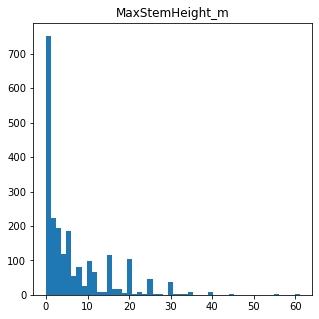

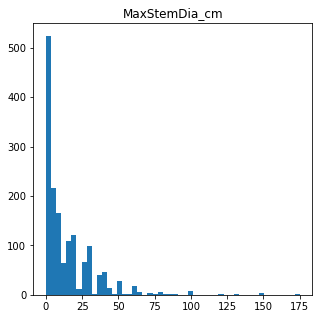

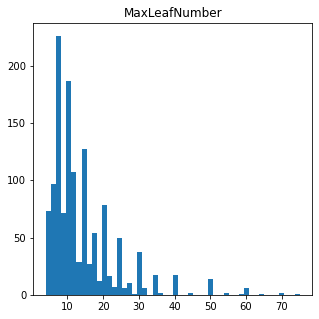

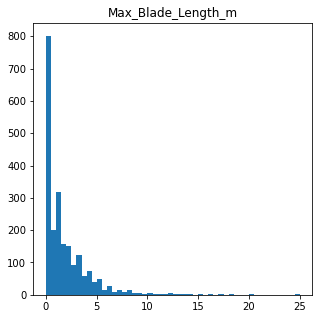

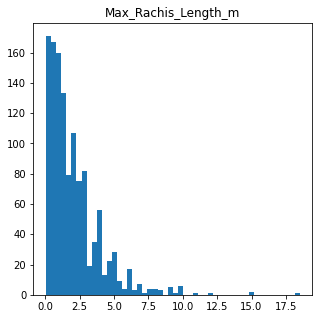

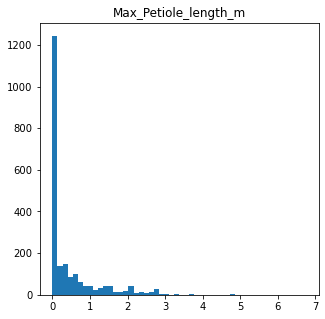

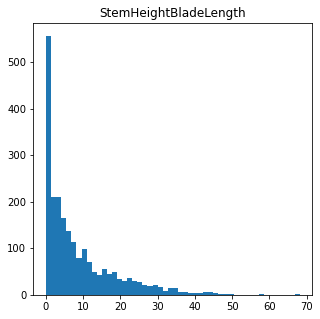

In [37]:
kissling=['MaxStemHeight_m','MaxStemDia_cm','MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m','Max_Petiole_length_m','StemHeightBladeLength']

palms_all_variables.loc[:,kissling]=palms_all_variables[kissling].astype('float')
# palms_all_variables[kissling]=logMatrix(palms_all_variables[kissling].astype('float'))
for i in kissling:
    fig,ax=plt.subplots(figsize=(5,5))
    ax.hist(sorted(palms_all_variables[kissling][i].dropna()),bins=50)
    plt.title('%s'%(i))
    plt.show()

In [38]:
# morphological variables need log transformation.
# none has negative variables, so just to regular log transform
palms_all_variables[kissling].describe()
palms_all_variables.loc[:,kissling]=logMatrix(palms_all_variables[kissling].astype('float'))
palms_all_variables[kissling].describe()

,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m,StemHeightBladeLength
count,2195.000000,1560.000000,1286.000000,2195.000000,1216.000000,2195.000000,2195.000000
mean,0.609851,0.945170,1.119724,0.329554,0.417973,0.119077,0.736428
std,0.486393,0.474259,0.225305,0.292622,0.229786,0.170914,0.493113
min,0.000000,0.000000,0.698970,0.000000,0.021189,0.000000,0.000000
25%,0.000000,0.544068,0.954243,0.000000,0.230449,0.000000,0.365113
50%,0.602060,0.954243,1.079181,0.311754,0.397940,0.000000,0.778151
75%,1.041393,1.322219,1.255273,0.544068,0.579784,0.190332,1.128076
max,1.792392,2.245513,1.880814,1.414973,1.290035,0.889302,1.839604


In [39]:
palms_all_variables[kissling].isna().describe()

,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m,StemHeightBladeLength
count,2195,2195,2195,2195,2195,2195,2195
unique,1,2,2,1,2,1,1
top,False,False,False,False,False,False,False
freq,2195,1560,1286,2195,1216,2195,2195


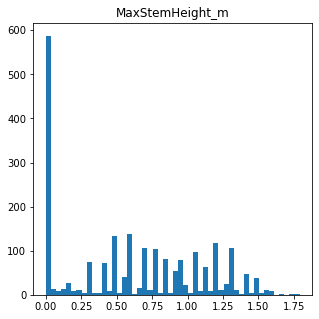

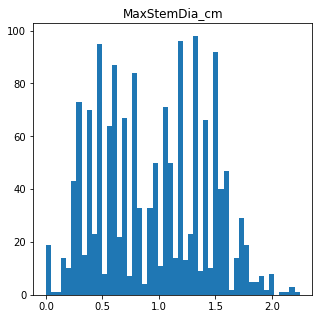

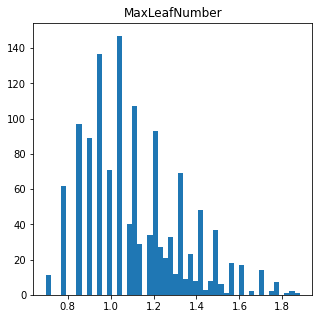

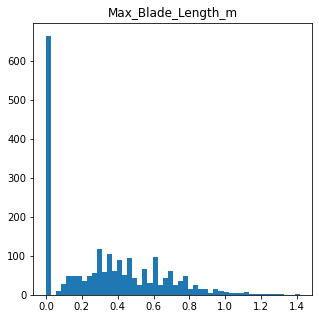

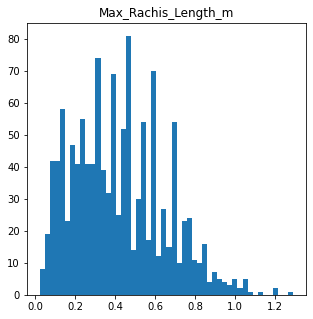

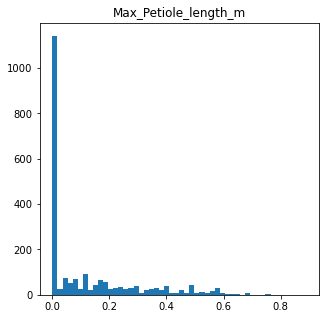

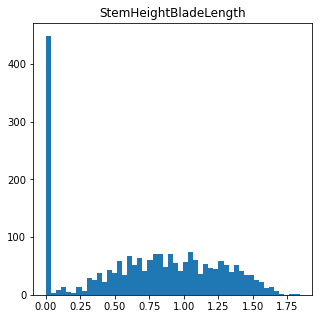

In [40]:
kissling=['MaxStemHeight_m','MaxStemDia_cm','MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m',
          'Max_Petiole_length_m','StemHeightBladeLength']
for i in kissling:
    fig,ax=plt.subplots(figsize=(5,5))
    ax.hist(sorted(palms_all_variables[kissling][i].dropna()),bins=50)
    plt.title('%s'%(i))
    plt.show()

## 8. Checking Chelsa variables

Less species than the database above. We first cleaned the GBIF coordinate records and removed points falling on bodies of water, country centroids (< 5km from a centroid), coordinates in countries where species are not native, and coordinates in botanical gardens or main cities.

### LogTransforming Chelsa variables

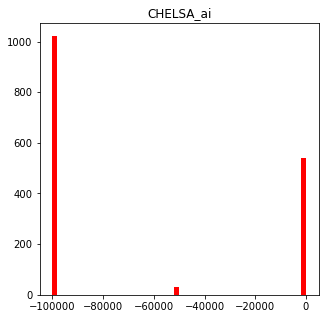

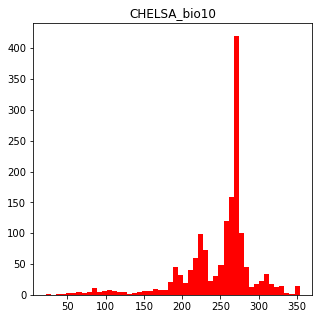

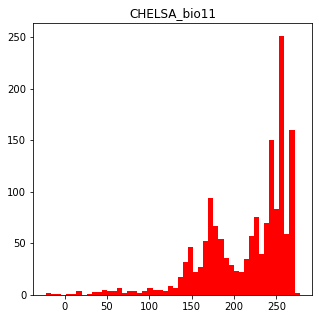

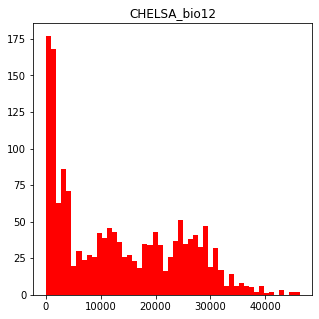

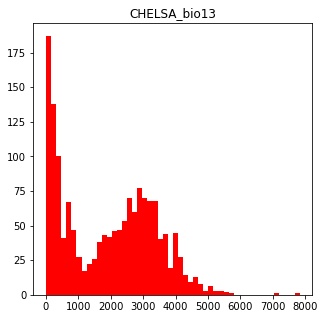

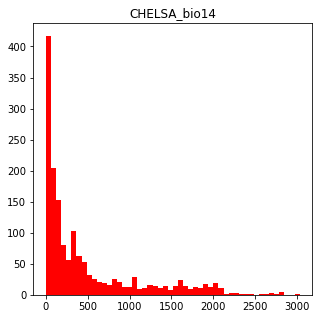

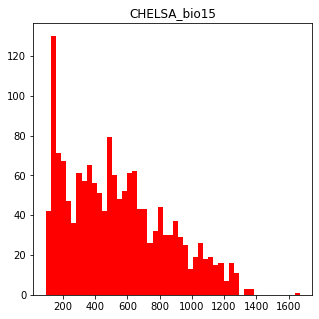

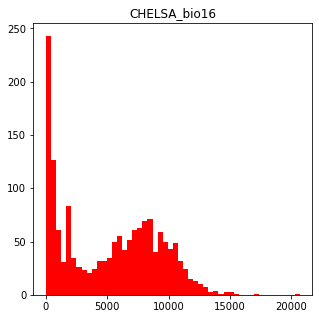

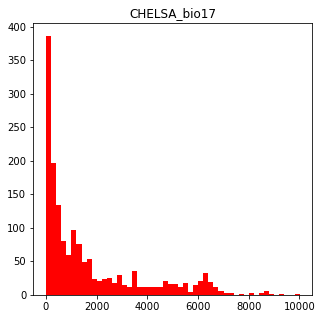

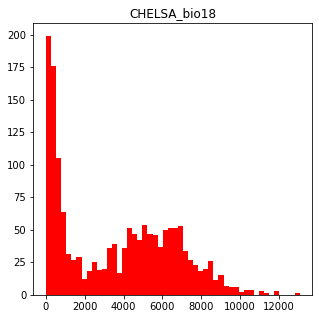

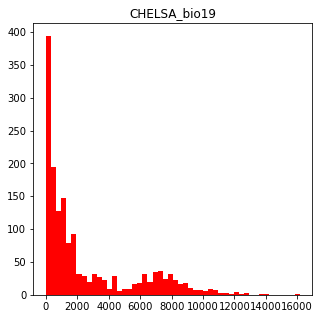

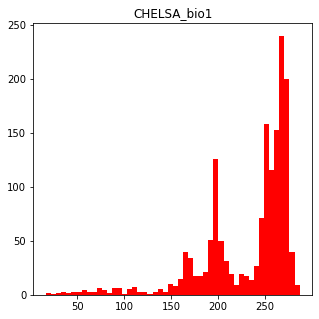

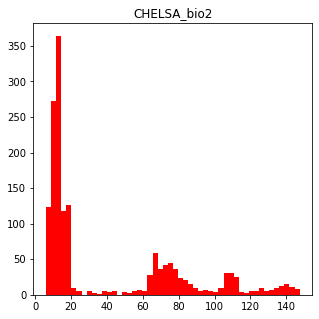

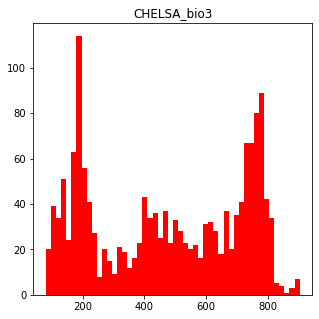

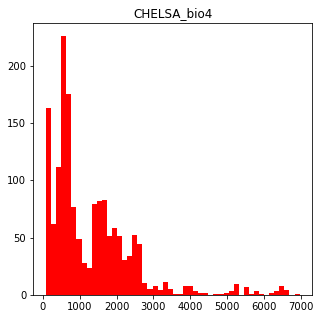

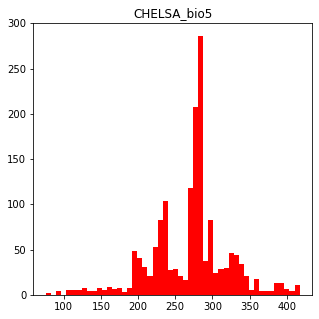

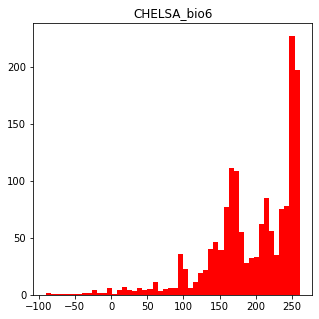

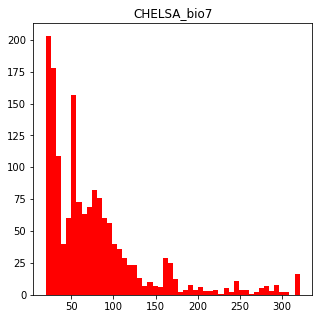

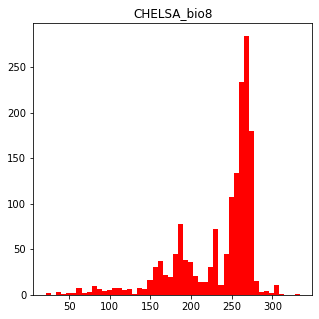

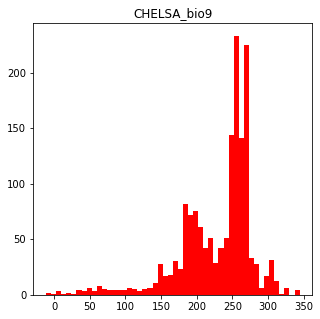

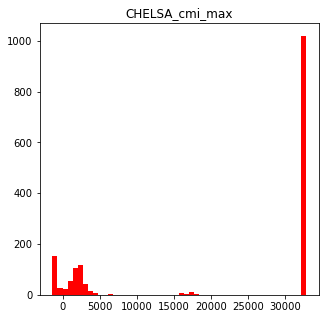

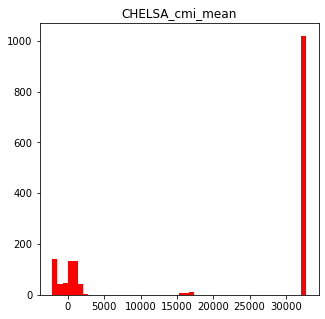

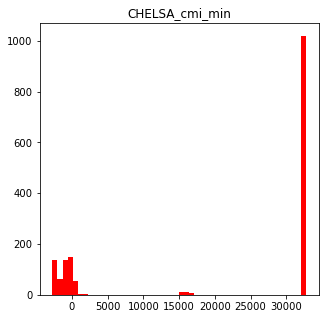

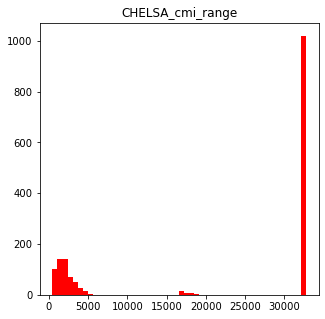

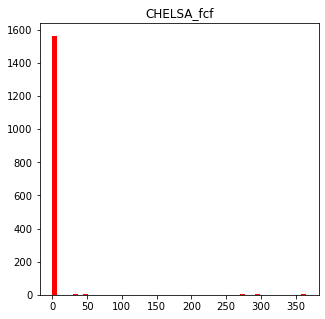

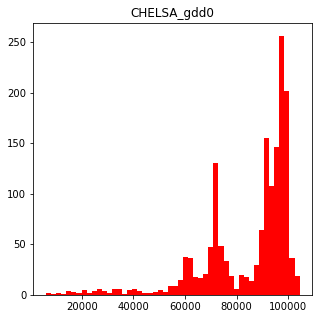

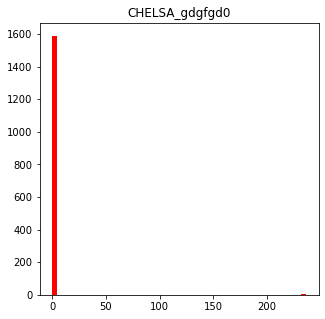

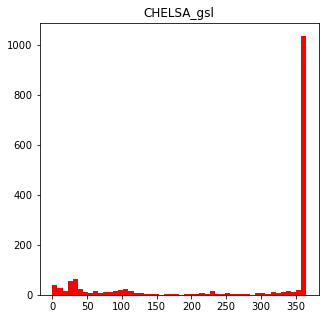

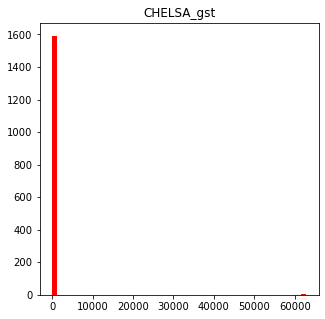

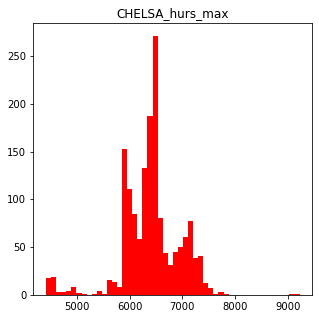

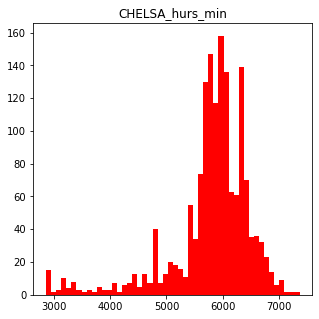

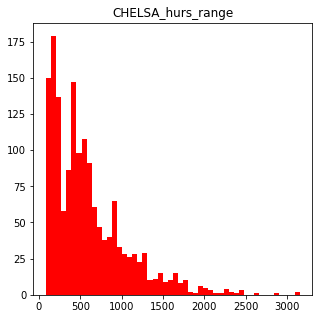

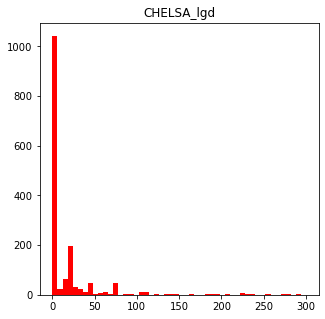

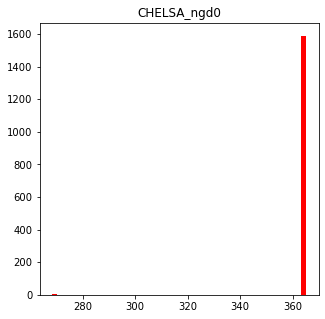

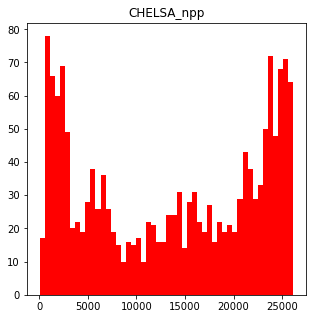

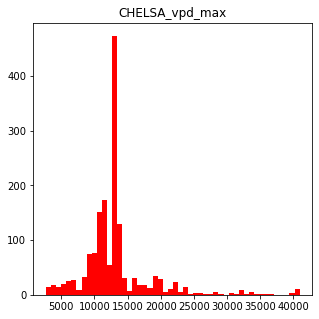

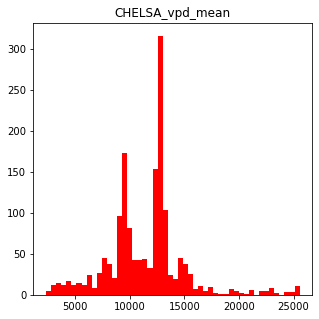

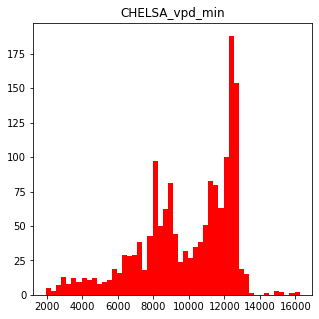

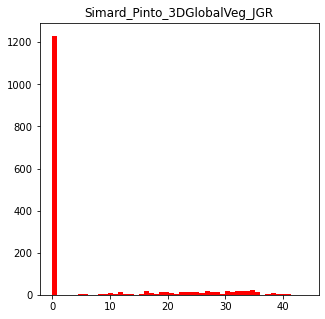

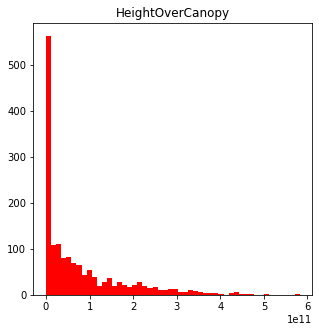

In [41]:
BioVar=['CHELSA_ai', 'CHELSA_bio10', 'CHELSA_bio11', 'CHELSA_bio12',
       'CHELSA_bio13', 'CHELSA_bio14', 'CHELSA_bio15', 'CHELSA_bio16',
       'CHELSA_bio17', 'CHELSA_bio18', 'CHELSA_bio19', 'CHELSA_bio1',
       'CHELSA_bio2', 'CHELSA_bio3', 'CHELSA_bio4', 'CHELSA_bio5',
       'CHELSA_bio6', 'CHELSA_bio7', 'CHELSA_bio8', 'CHELSA_bio9',
       'CHELSA_cmi_max', 'CHELSA_cmi_mean', 'CHELSA_cmi_min',
       'CHELSA_cmi_range', 'CHELSA_fcf', 'CHELSA_gdd0', 'CHELSA_gdgfgd0',
       'CHELSA_gsl', 'CHELSA_gst', 'CHELSA_hurs_max', 'CHELSA_hurs_min',
       'CHELSA_hurs_range', 'CHELSA_lgd', 'CHELSA_ngd0', 'CHELSA_npp',
       'CHELSA_vpd_max', 'CHELSA_vpd_mean', 'CHELSA_vpd_min',
       'Simard_Pinto_3DGlobalVeg_JGR','HeightOverCanopy']

for i in BioVar:
    fig,ax=plt.subplots(figsize=(5,5))
    ax.hist(sorted(palms_all_variables[BioVar][i].dropna()),color='r',bins=50)
    plt.title('%s'%(i))
    plt.show()

In [42]:
pd.set_option('display.max_columns', None)
palms_all_variables[BioVar].describe()

,CHELSA_ai,CHELSA_bio10,CHELSA_bio11,CHELSA_bio12,CHELSA_bio13,CHELSA_bio14,CHELSA_bio15,CHELSA_bio16,CHELSA_bio17,CHELSA_bio18,CHELSA_bio19,CHELSA_bio1,CHELSA_bio2,CHELSA_bio3,CHELSA_bio4,CHELSA_bio5,CHELSA_bio6,CHELSA_bio7,CHELSA_bio8,CHELSA_bio9,CHELSA_cmi_max,CHELSA_cmi_mean,CHELSA_cmi_min,CHELSA_cmi_range,CHELSA_fcf,CHELSA_gdd0,CHELSA_gdgfgd0,CHELSA_gsl,CHELSA_gst,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR,HeightOverCanopy
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1.593000e+03
mean,-65096.241879,247.783741,214.450408,13428.019146,1927.921218,475.575016,540.640301,5245.437539,1654.199623,3628.657878,2569.621783,231.795669,39.924357,475.478657,1311.690835,270.042059,192.240113,78.186127,233.194288,229.530132,21605.318895,21218.200565,20879.762398,21972.254237,3.211864,84582.544570,0.703390,279.931890,309.653798,6405.626805,5795.496547,596.500942,17.754865,364.759573,13645.892969,13257.047395,11450.458255,9859.468613,5.675455,7.578986e+10
std,47184.695071,48.812502,51.714044,11112.019491,1425.086580,611.765971,307.938513,3947.937449,2003.608528,2945.352110,3048.582653,48.531923,39.662677,241.842570,1158.215762,52.196756,61.526075,60.620445,49.318666,52.411819,15048.872281,15553.437254,16001.248977,14533.750866,27.759587,17714.996274,12.555908,134.759264,2216.957141,553.324262,727.902606,455.700548,42.190058,4.447800,8920.251032,5360.554857,3558.715941,2642.489851,11.266200,9.753637e+10
min,-99999.000000,22.000000,-22.000000,11.000000,3.000000,0.000000,95.000000,6.000000,0.000000,0.000000,0.000000,17.000000,6.000000,81.000000,83.000000,76.000000,-90.000000,20.000000,21.500000,-11.500000,-1388.000000,-2122.000000,-2756.000000,447.000000,0.000000,6181.000000,0.000000,0.000000,19.000000,4417.000000,2858.000000,85.000000,0.000000,268.500000,21.000000,2684.500000,2322.000000,1943.000000,0.000000,0.000000e+00
25%,-99999.000000,225.500000,177.000000,2682.000000,416.000000,54.000000,288.000000,949.500000,209.000000,564.000000,327.000000,198.500000,12.000000,212.000000,528.000000,236.500000,160.500000,33.000000,199.500000,198.500000,2167.500000,814.000000,-415.000000,2472.000000,0.000000,72423.000000,0.000000,181.000000,198.500000,6092.000000,5642.000000,245.500000,0.000000,365.000000,4562.000000,10862.000000,9436.000000,8148.000000,0.000000,4.537313e-01
50%,-99999.000000,263.500000,232.500000,11531.000000,2045.000000,190.000000,503.000000,5551.000000,805.000000,3622.000000,1144.000000,252.500000,15.000000,481.000000,863.000000,279.500000,205.500000,60.000000,255.500000,248.500000,32767.000000,32767.000000,32767.000000,32767.000000,0.000000,92213.000000,0.000000,365.000000,253.000000,6424.000000,5915.000000,476.500000,0.000000,365.000000,14403.000000,13020.000000,12215.000000,10561.000000,0.000000,3.650000e+10
75%,0.114142,272.500000,255.500000,23265.000000,3077.000000,624.500000,749.000000,8425.500000,2363.000000,6152.000000,3854.000000,266.500000,72.000000,723.000000,1831.500000,293.500000,247.500000,95.000000,268.500000,263.500000,32767.000000,32767.000000,32767.000000,32767.000000,0.000000,97274.000000,0.000000,365.000000,265.500000,6662.500000,6240.000000,809.000000,19.000000,365.000000,22645.000000,13564.000000,12938.000000,12211.500000,0.000000,1.120000e+11
max,3.976216,353.500000,277.500000,46256.000000,7828.000000,3035.000000,1669.000000,20693.000000,10013.000000,13067.000000,16152.000000,286.500000,147.500000,904.000000,6972.000000,417.500000,260.500000,321.000000,333.500000,344.500000,3

In [43]:
BioVar_wneg=['CHELSA_ai','CHELSA_bio11','CHELSA_bio6','CHELSA_bio9','CHELSA_cmi_max','CHELSA_cmi_mean','CHELSA_cmi_min']
BioVar_woneg=['CHELSA_bio10','CHELSA_bio12','CHELSA_bio13', 'CHELSA_bio14', 'CHELSA_bio15', 'CHELSA_bio16',
       'CHELSA_bio17', 'CHELSA_bio18', 'CHELSA_bio19', 'CHELSA_bio1','CHELSA_bio2', 'CHELSA_bio3', 'CHELSA_bio4',
       'CHELSA_bio5','CHELSA_bio7', 'CHELSA_bio8','CHELSA_cmi_range', 'CHELSA_fcf', 'CHELSA_gdd0', 'CHELSA_gdgfgd0',
       'CHELSA_gsl', 'CHELSA_gst', 'CHELSA_hurs_max', 'CHELSA_hurs_min',
       'CHELSA_hurs_range', 'CHELSA_lgd', 'CHELSA_ngd0', 'CHELSA_npp',
       'CHELSA_vpd_max', 'CHELSA_vpd_mean', 'CHELSA_vpd_min','Simard_Pinto_3DGlobalVeg_JGR','HeightOverCanopy']

In [44]:
# trasform the variables that we are interested in and have no negative values
palms_all_variables.loc[:,BioVar_woneg]=logMatrix(palms_all_variables[BioVar_woneg].astype('float'))
palms_all_variables[BioVar_woneg].describe()

,CHELSA_bio10,CHELSA_bio12,CHELSA_bio13,CHELSA_bio14,CHELSA_bio15,CHELSA_bio16,CHELSA_bio17,CHELSA_bio18,CHELSA_bio19,CHELSA_bio1,CHELSA_bio2,CHELSA_bio3,CHELSA_bio4,CHELSA_bio5,CHELSA_bio7,CHELSA_bio8,CHELSA_cmi_range,CHELSA_fcf,CHELSA_gdd0,CHELSA_gdgfgd0,CHELSA_gsl,CHELSA_gst,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR,HeightOverCanopy
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,2.383067,3.852245,3.051259,2.170620,2.651009,3.466161,2.763122,3.241122,3.022358,2.352021,1.416154,2.602695,2.957575,2.423819,1.798009,2.355332,4.083293,0.039594,4.912195,0.007382,2.307636,2.354210,3.804911,3.758971,2.656187,0.539020,2.563157,3.956753,4.092043,4.035476,3.973001,0.314349,7.380085
std,0.120224,0.602883,0.560735,0.835587,0.285062,0.589212,0.775018,0.695407,0.657329,0.131799,0.403004,0.277521,0.394722,0.093772,0.288011,0.125445,0.601149,0.290608,0.132429,0.131598,0.470235,0.154779,0.039338,0.063860,0.331130,0.762399,0.006026,0.482378,0.164121,0.151043,0.147171,0.585760,5.044809
min,1.361728,1.079181,0.602060,0.000000,1.982271,0.845098,0.000000,0.000000,0.000000,1.255273,0.845098,1.913814,1.924279,1.886491,1.322219,1.352183,2.651278,0.000000,3.791129,0.000000,0.000000,1.301030,3.645226,3.456214,1.934498,0.000000,2.430559,1.342423,3.429025,3.366049,3.288696,0.000000,0.000000
25%,2.355068,3.428621,2.620136,1.740363,2.460898,2.977952,2.322219,2.752048,2.515874,2.299943,1.113943,2.328380,2.723456,2.375664,1.531479,2.302114,3.393224,0.000000,4.859883,0.000000,2.260071,2.299943,3.784831,3.751510,2.391817,0.000000,2.563481,3.659250,4.035950,3.974834,3.911104,0.000000,0.162484
50%,2.422426,4.061905,3.310906,2.281033,2.702431,3.744449,2.906335,3.559068,3.058805,2.403978,1.204120,2.683047,2.936514,2.447933,1.785330,2.409087,4.515450,0.000000,4.964797,0.000000,2.563481,2.404834,3.807873,3.772028,2.678973,0.000000,2.563481,4.158483,4.114644,4.086929,4.023746,0.000000,10.562293
75%,2.436957,4.366722,3.488269,2.796227,2.875061,3.925647,3.373647,3.789087,3.586024,2.427324,1.863323,2.859739,3.263044,2.469085,1.982271,2.430559,4.515450,0.000000,4.988001,0.000000,2.563481,2.425697,3.823702,3.795254,2.908485,1.301030,2.563481,4.354992,4.132420,4.111901,4.086805,0.000000,11.049218
max,2.549616,4.665177,3.893706,3.482302,3.222716,4.315844,4.000608,4.116209,4.208253,2.458638,2.171726,2.956649,3.843420,2.621695,2.507856,2.524396,4.515450,2.563481,5.018676,2.375664,2.563481,4.797991,3.964872,3.867467,3.498862,2.478566,2.563481,4.417488,4.612344,4.407578,4.210613,1.653213,11.764923


In [45]:
# trasform the variables that we are interested in and have negative values
palms_all_variables.loc[:,BioVar_wneg]=logMatrixWNeg(palms_all_variables[BioVar_wneg].astype('float'))
palms_all_variables[BioVar_wneg].describe()

,CHELSA_ai,CHELSA_bio11,CHELSA_bio6,CHELSA_bio9,CHELSA_cmi_max,CHELSA_cmi_mean,CHELSA_cmi_min
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,1.786549,2.358831,2.435165,2.366079,4.046267,4.070371,4.056392
std,2.391223,0.148103,0.151005,0.156992,0.764002,0.688524,0.712958
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.301030,2.400538,2.324282,3.551023,3.467904,3.369587
50%,0.000000,2.407391,2.472025,2.416641,4.533467,4.542701,4.550522
75%,5.000000,2.444825,2.529559,2.440909,4.533467,4.542701,4.550522
max,5.000017,2.477844,2.545925,2.552668,4.533467,4.542701,4.550522


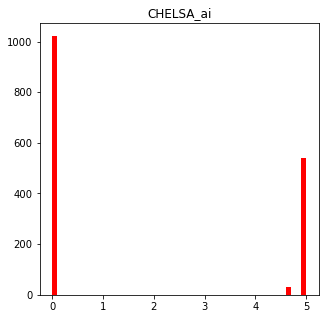

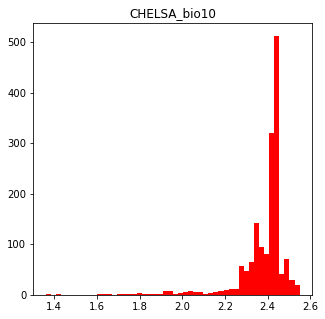

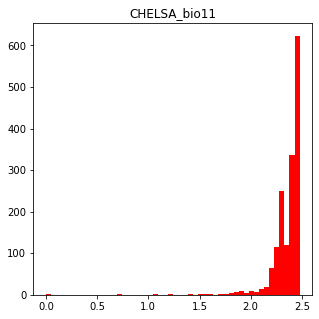

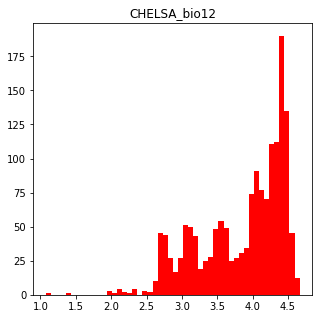

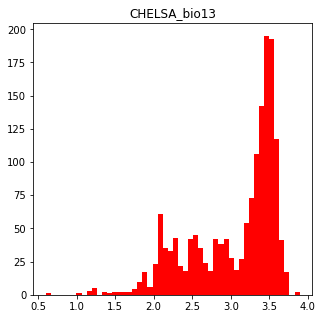

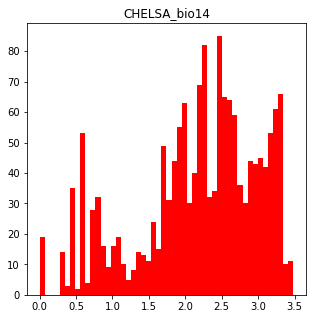

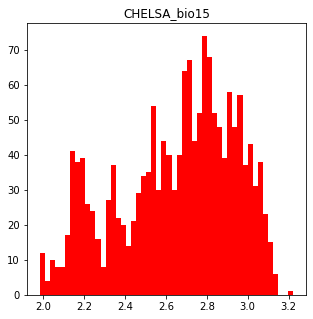

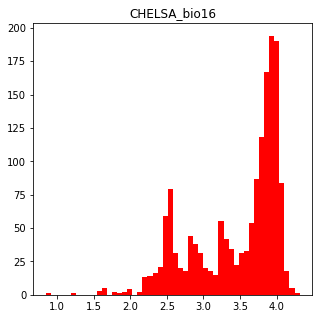

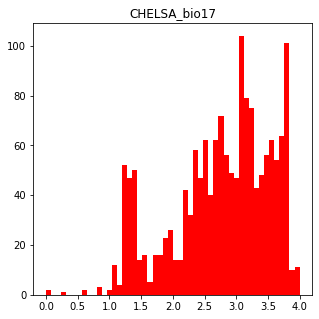

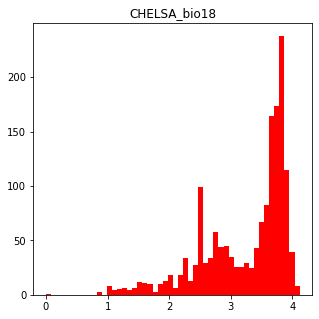

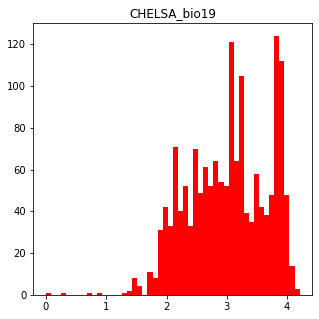

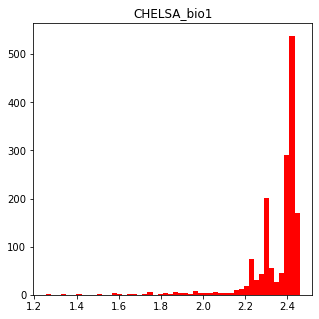

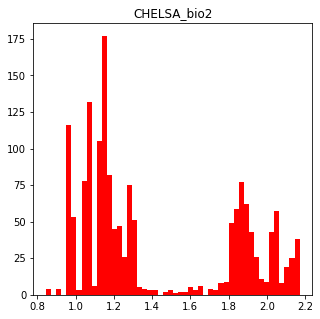

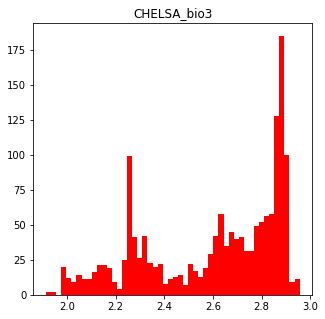

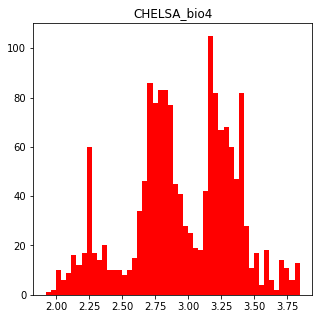

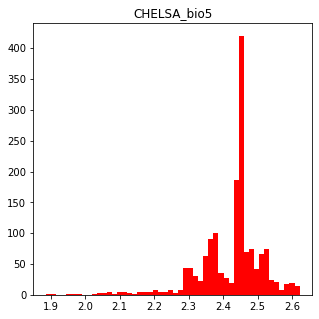

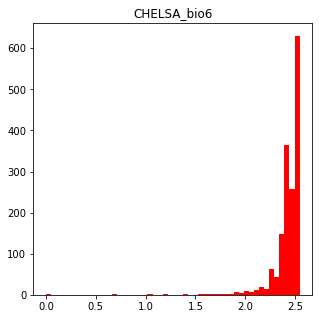

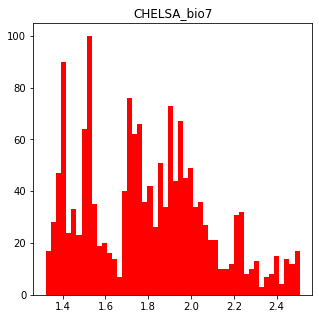

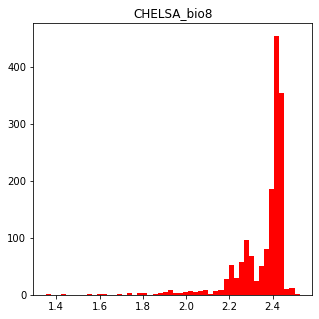

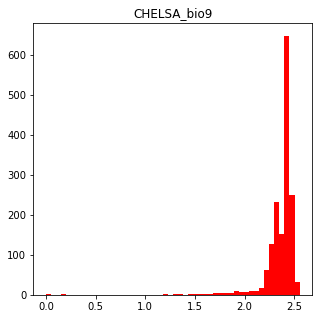

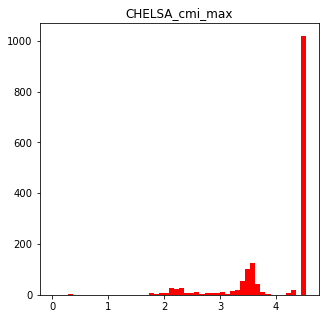

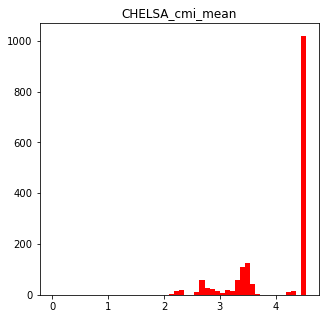

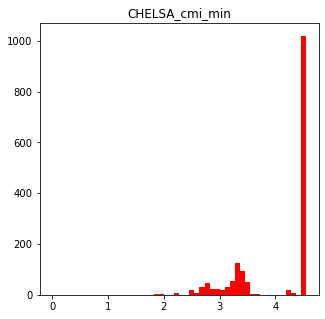

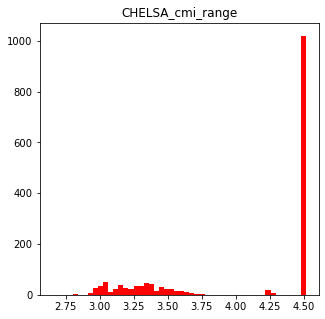

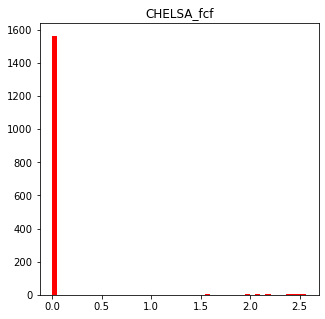

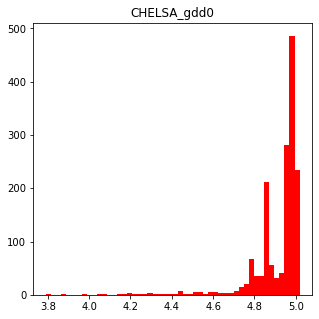

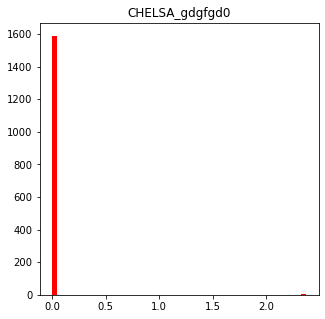

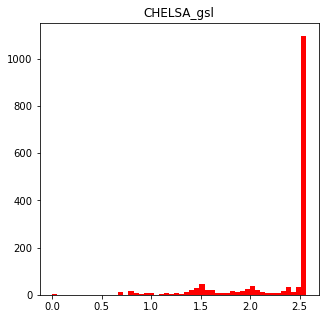

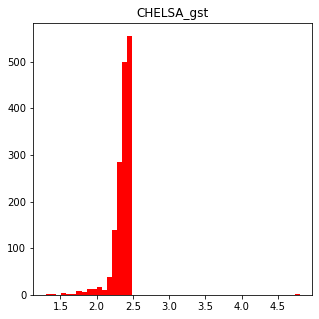

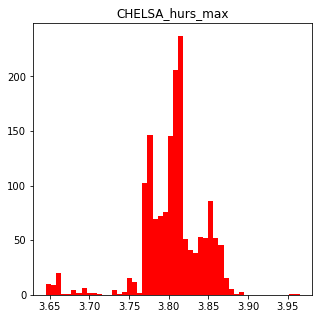

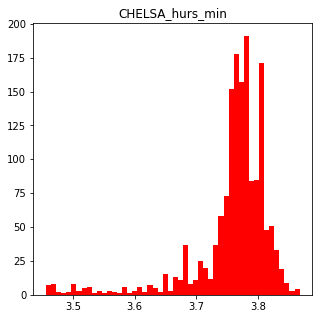

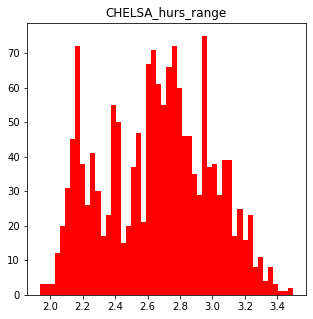

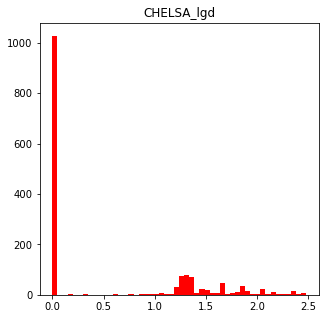

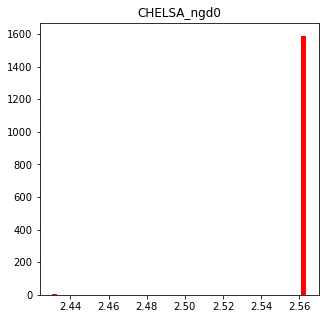

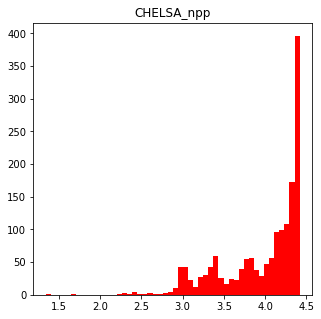

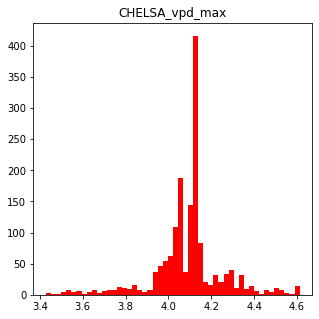

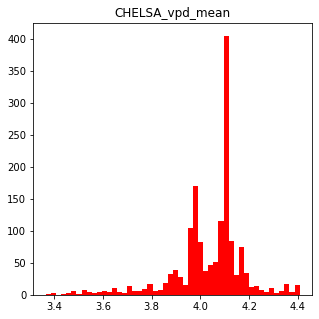

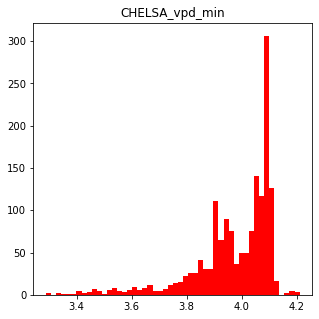

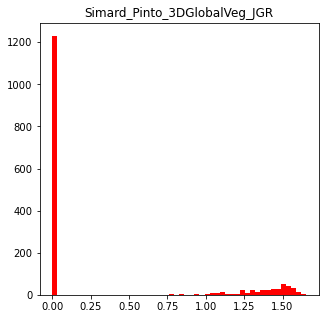

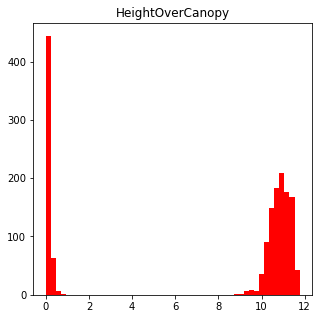

In [46]:
for i in BioVar:
    fig,ax=plt.subplots(figsize=(5,5))
    ax.hist(sorted(palms_all_variables[BioVar][i].dropna()),color='r',bins=50)
    plt.title('%s'%(i))
    plt.show()

### -> Checkpoint DB with Chelsa, Kissling, no climbing, after transforming

In [47]:
palms_all_variables.to_csv('../data_files/palms_all_variables_temp4_20220620.txt',sep='\t')
# palms_all_variables=pd.read_csv('../data_files/palms_all_variables_temp4_20220620.txt',sep='\t')
palms_all_variables

,Unnamed: 0.1,Unnamed: 0,index,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,CHELSA_ai,CHELSA_bio10,CHELSA_bio11,CHELSA_bio12,CHELSA_bio13,CHELSA_bio14,CHELSA_bio15,CHELSA_bio16,CHELSA_bio17,CHELSA_bio18,CHELSA_bio19,CHELSA_bio1,CHELSA_bio2,CHELSA_bio3,CHELSA_bio4,CHELSA_bio5,CHELSA_bio6,CHELSA_bio7,CHELSA_bio8,CHELSA_bio9,CHELSA_cmi_max,CHELSA_cmi_mean,CHELSA_cmi_min,CHELSA_cmi_range,CHELSA_fcf,CHELSA_gdd0,CHELSA_gdgfgd0,CHELSA_gsl,CHELSA_gst,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR,tip_name,dissection,induplicate,ind_variable,ind_cospalmate,ind_pinnate,ind_entire,ind_bipinnate,reduplicate,red_variable,red_cospalmate,red_pinnate,red_entire,plication,dissect,shape,variation,cospalmate_binomial,pinnate_binomial,entire_binomial,variable_binomial,bipinnate_binomial,PalmTribe,PalmSubfamily,Climbing,Acaulescent,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m,UnderstoreyCanopy,StemHeightBladeLength,HeightOverCanopy
0,0,0,0,Acrocomia_aculeata,80.0,8.555854,-75.696278,2.423127e+09,1.0,2009.0,0.0,2.353147,2.310693,3.847449,3.094296,2.241795,2.642465,3.493737,2.757016,3.208173,2.915400,2.306425,1.079181,2.431364,3.144263,2.366423,2.425697,1.748188,2.297761,2.328380,4.533467,4.542701,4.550522,4.51545,0.0,4.866211,0.0,2.563481,2.306425,3.798582,3.762378,2.561101,0.00000,2.563481,3.995898,4.051808,3.996030,3.949634,0.0,Acrocomia_aculeata,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,reduplicate,dissected,pinnate,not_variable,False,True,False,False,False,Cocoseae,Arecoideae,0.0,0.0,1.113943,1.707570,1.491362,0.653213,0.544068,0.000000,canopy,1.217484,11.190332
1,1,1,1,Acrocomia_crispa,514.5,21.616574,-77.756928,1.929436e+09,NaN,1916.0,0.0,2.279895,2.231724,3.307068,2.466868,1.963788,2.547775,2.889862,2.484300,2.613842,2.649335,2.226600,1.041393,2.250420,3.221675,2.295567,2.366423,1.763428,2.216166,2.267172,4.533467,4.542701,4.550522,4.51545,0.0,4.786844,0.0,2.332438,2.216166,3.780605,3.769230,2.195900,1.30103,2.563481,3.562412,3.949536,3.891147,3.826723,0.0,Acrocomia_crispa,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,reduplicate,dissected,pinnate,not_variable,False,True,False,False,False,Cocoseae,Arecoideae,0.0,0.0,1.278754,1.556303,1.204120,0.602060,NaN,0.217484,canopy,1.355068,11.335458
2,2,2,2,Acrocomia_emensis,NaN,-20.775000,-47.308334,2.452918e+09,4.0,1990.5,0.0,2.423246,2.425697,3.919836,3.179982,2.370143,2.820201,3.615582,2.860338,3.615582,2.986100,2.407391,1.113943,2.515211,2.920645,2.437751,2.515874,1.568202,2.423246,2.419129,4.533467,4.542701,4.550522,4.51545,0.0,4.968525,0.0,2.563481,2.407391,3.801472,3.764288,2.739572,0.00000,2.563481,4.091456,4.111901,4.100922,4.093264,0.0,Acrocomia_emensis,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,reduplicate,dissected,pinnate,not_variable,False,True,False,False,False,Cocoseae,Arecoideae,0.0,1.0,0.000000,NaN,NaN,0.000000,NaN,0.000000,understorey,0.000000,0.000000
3,3,3,3,Acrocomia_glaucescens,NaN,-16.655692,-54.684167,1.261911e+09,NaN,2009.0,0.0,2.432167,2.446382,4.200878,3.344981,2.489958,2.748188,3.801129,3.017033,3.790672,3.151370,2.422426,1.176091,2.684845,2.693727,2.446382,2.532117,1.477121,2.431364,2.431364,4.533467,4.542701,4.550522,4.51545,0.0,4.982868,0.0,2.563481,2.422426,3.806248,3.777862,2.614370,0.00000,2.563481,4.282010,4.123362,4.110152,4.092264,0.0,Acrocomia_glaucescens,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,reduplicate,dissected,pinnate,not_variable,False,True,False,False,False,Cocoseae,Arecoideae,0.0,0.0,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000
4,4,4,4,Acrocomia_hassleri,850.0,-23.809420,-55.733195,1.258407e+09,4.0,1997.0,0.0,2.430559,2.425697,4.015402,3.200987,2.631444,2.600973,3.616843,3.195623,3.566025,3.201943,2.410777,1.146128,2.510545,3.007748,2.443263,2.513883,1.623249,2.430559,2.408240,4.533467,4.542701,4

## 9. Annotating biomes

In [48]:
# create dictionaries from the biome database. To make things faster, the dictionaries will be used to map the data to the main DB instead of using embebed loops, as I foolishly do at some point above. I'll have to fix that some time in the future.
biome_columns=['1_Tropical_and_subtropical_moist_broadleaf_forests','2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests','4_Temperate_broadleaf_and_mixed_forests','5_Temperate_coniferous_forest',
       '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands','8_Temperate_grasslands_savannas_and_shrublands','12_Mediterranean_Forests_woodlands_and_scrubs','13_Desert_and_xeric_shrublands', 'species_name']

biome_metadict={}
for col in biome_columns:
    tempdict=dict(zip(biome_bdb_sf['species_name'],biome_bdb_sf[col]))
    biome_metadict[col]=tempdict
# biome_metadict

# annotate the main DB
for key,value in biome_metadict.items():
    palms_all_variables[key]=palms_all_variables['species'].map(value)
palms_all_variables[['2_Tropical_and_subtropical_dry_broadleaf_forests','species']]

palms_all_variables[biome_columns].describe()

,1_Tropical_and_subtropical_moist_broadleaf_forests,2_Tropical_and_subtropical_dry_broadleaf_forests,3_Tropical_and_subtropical_coniferous_forests,4_Temperate_broadleaf_and_mixed_forests,5_Temperate_coniferous_forest,7_Tropical_and_subtropical_grasslands_savannas_and_shrublands,8_Temperate_grasslands_savannas_and_shrublands,12_Mediterranean_Forests_woodlands_and_scrubs,13_Desert_and_xeric_shrublands
count,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000
mean,0.873430,0.069565,0.001932,0.002415,0.003382,0.057971,0.000483,0.002899,0.015459
std,0.332571,0.254474,0.043927,0.049100,0.058068,0.233745,0.021979,0.053773,0.123399
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Understanding the forest categories to know what species to consider for canopy and understory analyses

**1_Tropical_and_subtropical_moist_broadleaf_forests (has canopy): 2282 species**  
ow variability in annual temperature and high levels of rainfall (>200 centimetres (79 in) annually). Forest composition is dominated by evergreen and semi-evergreen deciduous tree species. The canopy can be divided into five layers: overstory canopy with emergent crowns, a medium layer of canopy, lower canopy, shrub level, and finally understory.

**2_Tropical_and_subtropical_dry_broadleaf_forests (has canopy) 157 species:**  
Though these forests occur in climates that are warm year-round, and may receive several hundred centimeters of rain per year, they have long dry seasons which last several months and vary with geographic location. Deciduous trees predominate in most of these forests, and during the drought a leafless period occurs, which varies with species type. Because trees lose moisture through their leaves, the shedding of leaves allows trees such as teak and mountain ebony to conserve water during dry periods. The newly bare trees open up the canopy layer, enabling sunlight to reach ground level and facilitate the growth of thick underbrush. Trees on moister sites and those with access to ground water tend to be evergreen. Infertile sites also tend to support evergreen trees. 

**3_Tropical_and_subtropical_coniferous_forests (has cannopy) 4 species:**  
 These forests are found predominantly in North and Central America and experience low levels of precipitation and moderate variability in temperature. Tropical and subtropical coniferous forests are characterized by diverse species of conifers, whose needles are adapted to deal with the variable climatic conditions. These biomes feature a thick, closed canopy which blocks light to the floor and allows little underbrush. As a result, the ground is often covered with fungi and ferns.

**4_Temperate_broadleaf_and_mixed_forests (has cannopy) 5 species:**  
These forests are richest and most distinctive in central China and eastern North America, with some other globally distinctive ecoregions in the Caucasus, the Himalayas, Southern Europe, Australasia, southern South America and the Russian Far East. The uppermost layer is the canopy composed of tall mature trees ranging from 30 to 61 m (100 to 200 ft) high. Below the canopy is the three-layered, shade-tolerant understory that is roughly 9 to 15 m (30 to 50 ft) shorter than the canopy. The top layer of the understory is the sub-canopy composed of smaller mature trees, saplings, and suppressed juvenile canopy layer trees awaiting an opening in the canopy. Below the sub-canopy is the shrub layer, composed of low growing woody plants. Typically the lowest growing (and most diverse) layer is the ground cover or herbaceous layer.

**5_Temperate_coniferous_forest (has cannopy) 7 species:**  
are found predominantly in areas with warm summers and cool winters, and vary in their kinds of plant life. In some, needleleaf trees dominate, while others are home primarily to broadleaf evergreen trees or a mix of both tree types. A separate habitat type, the tropical coniferous forests, occurs in more tropical climates. Temperate coniferous forests are common in the coastal areas of regions that have mild winters and heavy rainfall, or inland in drier climates or montane areas. Many species of trees inhabit these forests including pine, cedar, fir, and redwood. The understory also contains a wide variety of herbaceous and shrub species. Structurally, these forests are rather simple, consisting of 2 layers generally: an overstory and understory. However, some forests may support a layer of shrubs.

**7_Tropical_and_subtropical_grasslands_savannas_and_shrublands 122 species:**  
The biome is dominated by grass and/or shrubs located in semi-arid to semi-humid climate regions of subtropical and tropical latitudes. Grassland is dominated by grass and other herbaceous plants. Savanna is grassland with scattered trees. Shrubland is dominated by woody or herbaceous shrubs. Large expanses of land in the tropics do not receive enough rainfall to support extensive tree cover. The tropical and subtropical grasslands, savannas, and shrublands are characterized by rainfall levels between 90–150 centimetres (35–59 in) per year. Rainfall can be highly seasonal, with the entire year's rainfall sometimes occurring within a couple of weeks. African savannas occur between forest or woodland regions and grassland regions. Flora includes acacia and baobab trees, grass, and low shrubs. Acacia trees lose their leaves in the dry season to conserve moisture, while the baobab stores water in its trunk for the dry season. Many of these savannas are in Africa.

**8_Temperate_grasslands_savannas_and_shrublands 1 species:**  
The predominant vegetation in this biome consists of grass and/or shrubs. The climate is temperate and ranges from semi-arid to semi-humid. The habitat type differs from tropical grasslands in the annual temperature regime as well as the types of species found here. The habitat type is known as prairie in North America, pampas in South America, veld in Southern Africa and steppe in Asia. Generally speaking, these regions are devoid of trees, except for riparian or gallery forests associated with streams and rivers.

**12_Mediterranean_Forests_woodlands_and_scrubs (complex, check if there are palm species here and discuss) 6 species:**  
The biome is generally characterized by dry summers and rainy winters, although in some areas rainfall may be uniform. Summers are typically hot in low-lying inland locations but can be cool near colder seas. Winters are typically mild to cool in low-lying locations but can be cold in inland and higher locations. All these ecoregions are highly distinctive, collectively harboring 10% of the Earth's plant species. Vegetation types range from forests to woodlands, savannas, shrublands, and grasslands; "mosaic habitat" landscapes are common, where differing vegetation types are interleaved with one another in complex patterns created by variations in soil, topography, exposure to wind and sun, and fire history. Much of the woody vegetation in Mediterranean-climate regions is sclerophyll, which means 'hard-leaved' in Greek. Sclerophyll vegetation generally has small, dark leaves covered with a waxy outer layer to retain moisture in the dry summer months. 

**13_Desert_and_xeric_shrublands 32 species:**  
Deserts and xeric shrublands form the largest terrestrial biome, covering 19% of Earth's land surface area. Ecoregions in this habitat type vary greatly in the amount of annual rainfall they receive, usually less than 250 millimetres (10 in) annually except in the margins. Generally evaporation exceeds rainfall in these ecoregions. Temperature variability is also diverse in these lands. Many deserts, such as the Sahara, are hot year-round, but others, such as East Asia's Gobi, become quite cold in winter. Temperature extremes are a characteristic of most deserts. High daytime temperatures give way to cold nights because there is no insulation provided by humidity and cloud cover. The diversity of climatic conditions, though quite harsh, supports a rich array of habitats. Many of these habitats are ephemeral in nature, reflecting the paucity and seasonality of available water. Woody-stemmed shrubs and plants characterize vegetation in these regions. Above all, these plants have evolved to minimize water loss. Animal biodiversity is equally well adapted and quite diverse.




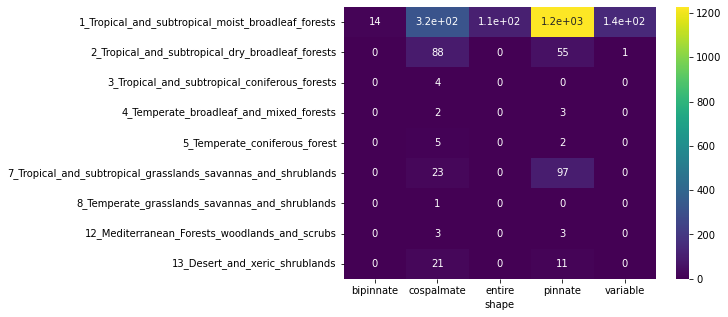

In [49]:
palms_all_variables[palms_all_variables['1_Tropical_and_subtropical_moist_broadleaf_forests']==1][['species','1_Tropical_and_subtropical_moist_broadleaf_forests']]
palms_all_variables[palms_all_variables['13_Desert_and_xeric_shrublands']==1]['shape'].describe()

# for col in ['1_Tropical_and_subtropical_moist_broadleaf_forests','2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests','4_Temperate_broadleaf_and_mixed_forests','5_Temperate_coniferous_forest',
#        '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands','8_Temperate_grasslands_savannas_and_shrublands','12_Mediterranean_Forests_woodlands_and_scrubs','13_Desert_and_xeric_shrublands']:
byshape=palms_all_variables.groupby('shape')[['1_Tropical_and_subtropical_moist_broadleaf_forests','2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests','4_Temperate_broadleaf_and_mixed_forests','5_Temperate_coniferous_forest',
       '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands','8_Temperate_grasslands_savannas_and_shrublands','12_Mediterranean_Forests_woodlands_and_scrubs','13_Desert_and_xeric_shrublands']].sum()

fig,ax=plt.subplots(figsize=(7,5),facecolor='w')
sns.heatmap(byshape.T,annot=True,cmap='viridis',ax=ax)
plt.savefig('../figures/habitat_heatmap.pdf',dpi=300)
plt.show()

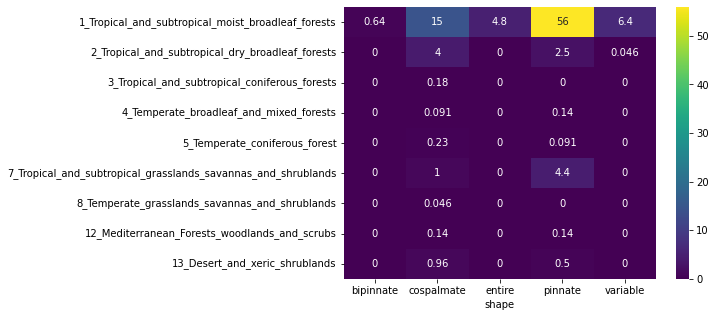

In [50]:
palms_all_variables[palms_all_variables['1_Tropical_and_subtropical_moist_broadleaf_forests']==1][['species','1_Tropical_and_subtropical_moist_broadleaf_forests']]
palms_all_variables[palms_all_variables['13_Desert_and_xeric_shrublands']==1]['shape'].describe()

total_palm_lineages=len(palms_all_variables)

byshape=palms_all_variables.groupby('shape')[['1_Tropical_and_subtropical_moist_broadleaf_forests','2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests','4_Temperate_broadleaf_and_mixed_forests','5_Temperate_coniferous_forest',
       '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands','8_Temperate_grasslands_savannas_and_shrublands','12_Mediterranean_Forests_woodlands_and_scrubs','13_Desert_and_xeric_shrublands']].sum()# .apply(lambda x:100 * x / total_palm_lineages)

byshape=(byshape*100)/total_palm_lineages

fig,ax=plt.subplots(figsize=(7,5),facecolor='w')
sns.heatmap(byshape.T,annot=True,cmap='viridis',ax=ax)
plt.savefig('../figures/habitat_heatmap_percentage.pdf',dpi=300)
plt.show()

In [51]:
# remove columns bioms 7,8,12,13
# create summary columns for biome and change species in bioms 7,8,12,13
palms_all_variables[palms_all_variables['UnderstoreyCanopy'].isna()]['species']

savanna_spp=palms_all_variables[(palms_all_variables['7_Tropical_and_subtropical_grasslands_savannas_and_shrublands']==1) |
                                                    (palms_all_variables['8_Temperate_grasslands_savannas_and_shrublands']==1) |
                                                    (palms_all_variables['12_Mediterranean_Forests_woodlands_and_scrubs']==1) |
                                                    (palms_all_variables['13_Desert_and_xeric_shrublands']==1)]['species'].values

forest_spp=palms_all_variables[(palms_all_variables['1_Tropical_and_subtropical_moist_broadleaf_forests']==1) |
                                                    (palms_all_variables['2_Tropical_and_subtropical_dry_broadleaf_forests']==1) |
                                                    (palms_all_variables['3_Tropical_and_subtropical_coniferous_forests']==1) |
                                                    (palms_all_variables['4_Temperate_broadleaf_and_mixed_forests']==1) |
                                                    (palms_all_variables['5_Temperate_coniferous_forest']==1)]['species'].values
in_both=list(set(savanna_spp).intersection(forest_spp))

print('Number in species in savannas: %s'%(len(savanna_spp)))
print('Number in species in forest: %s'%(len(forest_spp)))
print('Number in species in both: %s'%(len(in_both)))

for row in palms_all_variables.itertuples():
    if row.species in savanna_spp:
        palms_all_variables.loc[row.Index,'biomefilter']='savanna'
    if row.species in forest_spp:
        palms_all_variables.loc[row.Index,'biomefilter']='forest' # overwrites with forest species in both.
palms_all_variables['biomefilter']
palms_all_variables[~palms_all_variables['UnderstoreyCanopy'].isna()][['species','UnderstoreyCanopy','biomefilter']]

Number in species in savannas: 155
Number in species in forest: 1939
Number in species in both: 24


,species,UnderstoreyCanopy,biomefilter
0,Acrocomia_aculeata,canopy,forest
1,Acrocomia_crispa,canopy,forest
2,Acrocomia_emensis,understorey,savanna
4,Acrocomia_hassleri,understorey,savanna
6,Acrocomia_media,canopy,forest
...,...,...,...
2189,Veitchia_vitiensis,canopy,forest
2190,Verschaffeltia_splendida,canopy,forest
2192,Wallichia_marianneae,understorey,forest
2193,Wallichia_triandra,understorey,forest


####  -> Checkpoint DB with BIOCLIM, soil, Kissling, biomes, after transformation, with biomes and climbing species set to nans

In [52]:
palms_all_variables.to_csv('../data_files/palms_all_variables_temp5_20220620.txt',sep='\t')
# palms_all_variables=pd.read_csv('../data_files/palms_all_variables_temp5_20220620.txt',sep='\t')
palms_all_variables
palms_all_variables['CHELSA_bio1'].describe()

count    1593.000000
mean        2.352021
std         0.131799
min         1.255273
25%         2.299943
50%         2.403978
75%         2.427324
max         2.458638
Name: CHELSA_bio1, dtype: float64

In [53]:
genera=[]
for genus in list(palms_all_variables[palms_all_variables['shape']=='variable']['species'].values):
    genera.append(genus.split('_')[0])
print('Number of genera with intra-specific leaf shape variation: ',len(set(genera)))

Number of genera with intra-specific leaf shape variation:  17


## 10. Standardise all variables to have mean 0 and SD 1

In [54]:
palms_all_variables['HeightOverCanopy'].describe()

count    1593.000000
mean        7.380085
std         5.044809
min         0.000000
25%         0.162484
50%        10.562293
75%        11.049218
max        11.764923
Name: HeightOverCanopy, dtype: float64

In [55]:
from sklearn.preprocessing import StandardScaler

variables=['CHELSA_ai', 'CHELSA_bio10','CHELSA_bio11', 'CHELSA_bio12', 'CHELSA_bio13', 'CHELSA_bio14',
       'CHELSA_bio15', 'CHELSA_bio16', 'CHELSA_bio17', 'CHELSA_bio18','CHELSA_bio19', 'CHELSA_bio1',
       'CHELSA_bio2', 'CHELSA_bio3','CHELSA_bio4', 'CHELSA_bio5', 'CHELSA_bio6', 'CHELSA_bio7',
       'CHELSA_bio8', 'CHELSA_bio9', 'CHELSA_cmi_max', 'CHELSA_cmi_mean','CHELSA_cmi_min', 'CHELSA_cmi_range',
       'CHELSA_fcf', 'CHELSA_gdd0','CHELSA_gdgfgd0', 'CHELSA_gsl', 'CHELSA_gst', 'CHELSA_hurs_max',
       'CHELSA_hurs_min', 'CHELSA_hurs_range', 'CHELSA_lgd', 'CHELSA_ngd0','CHELSA_npp', 'CHELSA_vpd_max',
       'CHELSA_vpd_mean', 'CHELSA_vpd_min','Simard_Pinto_3DGlobalVeg_JGR',
       'MaxStemHeight_m', 'MaxStemDia_cm', 'MaxLeafNumber','Max_Blade_Length_m', 'Max_Rachis_Length_m',
       'Max_Petiole_length_m','StemHeightBladeLength','HeightOverCanopy']

for var in variables:
    scaler=StandardScaler()
    palms_all_variables['%s_stand'%(var)]=scaler.fit_transform(palms_all_variables[var].values.reshape(-1, 1))
    
palms_all_variables[['StemHeightBladeLength','StemHeightBladeLength_stand']].describe()

,StemHeightBladeLength,StemHeightBladeLength_stand
count,2195.000000,2.195000e+03
mean,0.736428,3.769195e-16
std,0.493113,1.000228e+00
min,0.000000,-1.493765e+00
25%,0.365113,-7.531715e-01
50%,0.778151,8.463195e-02
75%,1.128076,7.944160e-01
max,1.839604,2.237675e+00


In [56]:
palms_all_variables[['%s_stand'%(var) for var in variables]].describe()

,CHELSA_ai_stand,CHELSA_bio10_stand,CHELSA_bio11_stand,CHELSA_bio12_stand,CHELSA_bio13_stand,CHELSA_bio14_stand,CHELSA_bio15_stand,CHELSA_bio16_stand,CHELSA_bio17_stand,CHELSA_bio18_stand,CHELSA_bio19_stand,CHELSA_bio1_stand,CHELSA_bio2_stand,CHELSA_bio3_stand,CHELSA_bio4_stand,CHELSA_bio5_stand,CHELSA_bio6_stand,CHELSA_bio7_stand,CHELSA_bio8_stand,CHELSA_bio9_stand,CHELSA_cmi_max_stand,CHELSA_cmi_mean_stand,CHELSA_cmi_min_stand,CHELSA_cmi_range_stand,CHELSA_fcf_stand,CHELSA_gdd0_stand,CHELSA_gdgfgd0_stand,CHELSA_gsl_stand,CHELSA_gst_stand,CHELSA_hurs_max_stand,CHELSA_hurs_min_stand,CHELSA_hurs_range_stand,CHELSA_lgd_stand,CHELSA_ngd0_stand,CHELSA_npp_stand,CHELSA_vpd_max_stand,CHELSA_vpd_mean_stand,CHELSA_vpd_min_stand,Simard_Pinto_3DGlobalVeg_JGR_stand,MaxStemHeight_m_stand,MaxStemDia_cm_stand,MaxLeafNumber_stand,Max_Blade_Length_m_stand,Max_Rachis_Length_m_stand,Max_Petiole_length_m_stand,StemHeightBladeLength_stand,HeightOverCanopy_stand
count,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,1.593000e+03,2.195000e+03,1.560000e+03,1.286000e+03,2.195000e+03,1.216000e+03,2.195000e+03,2.195000e+03,1.593000e+03
mean,6.213904e-16,-5.406082e-15,-1.777820e-15,7.136650e-17,-1.686591e-16,2.582854e-16,-1.981536e-15,8.973780e-16,-3.486086e-16,-3.257491e-16,1.710287e-16,-5.125286e-16,-3.784716e-16,6.060229e-16,-6.670398e-16,-1.166675e-15,1.916302e-15,1.812911e-16,-5.211706e-16,1.068755e-15,5.130861e-16,-1.942089e-15,-1.345788e-15,-2.258081e-15,4.157935e-16,-7.965171e-15,4.100438e-16,2.058756e-16,4.273627e-16,1.069006e-14,-1.650072e-15,1.103951e-16,1.088897e-15,7.955466e-16,-1.112314e-16,-2.502009e-15,-1.280973e-16,-1.668331e-15,-6.453650e-17,2.162785e-16,-3.074820e-16,4.400316e-16,1.198737e-16,1.052760e-16,-3.704958e-16,3.769195e-16,-5.261886e-17
std,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000314e+00,1.000228e+00,1.000321e+00,1.000389e+00,1.000228e+00,1.000411e+00,1.000228e+00,1.000228e+00,1.000314e+00
min,-7.473622e-01,-8.497990e+00,-1.593195e+01,-4.601119e+00,-4.369208e+00,-2.598535e+00,-2.346670e+00,-4.449817e+00,-3.566355e+00,-4.662221e+00,-4.599385e+00,-8.323994e+00,-1.417444e+00,-2.483043e+00,-2.618601e+00,-5.731949e+00,-1.613141e+01,-1.652501e+00,-7.999231e+00,-1.507611e+01,-5.297813e+00,-5.913591e+00,-5.691313e+00,-2.382879e+00,-1.362887e-01,-8.468076e+00,-5.610993e-02,-4.908949e+00,-6.806567e+00,-4.060540e+00,-4.742432e+00,-2.180156e+00,-7.072281e-01,-2.201130e+01,-5.421376e+00,-4.041094e+00,-4.433407e+00,-4.651203e+00,-5.368192e-01,-1.254110e+00,-1.993577e+00,-1.868211e+00,-1.126470e+00,-1.727464e+00,-6.968656e-01,-1.493765e+00,-1.463366e+00
25%,-7.473622e-01,-2.329614e-01,-3.904012e-01,-7.028856e-01,-7.690943e-01,-5.150784e-01,-6.671195e-01,-8.288393e-01,-5.690721e-01,-7.035118e-01,-7.707609e-01,-3.952569e-01,-7.501312e-01,-9.887576e-01,-5.933095e-01,-5.137011e-01,-2.293813e-01,-9.257048e-01,-4.243647e-01,-2.663207e-01,-6.484277e-01,-8.752875e-01,-9.636203e-01,-1.148277e+00,-1.362887e-01,-3.951464e-01,-5.610993e-02,-1.011830e-01,-3.507194e-01,-5.105920e-01,-1.168622e-01,-7.986382e-01,-7.072281e-01,5.372338e-02,-6.169355e-01,-3.418899e-01,-4.

In [57]:
palms_all_variables[['%s_stand'%(var) for var in variables]]=palms_all_variables[['%s_stand'%(var) for var in variables]].astype('float')

# Final database, BIOCLIM, soil, Kissling, biomes, standardised

In [59]:
palms_all_variables.to_csv('../data_files/palms_alltraits_curated_20220620.csv',sep='\t')